<a href="https://colab.research.google.com/github/groda/big_data/blob/master/Hadoop_single_node_cluster_setup_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://github.com/groda/big_data"><div><img src="https://github.com/groda/big_data/blob/master/logo_bdb.png?raw=true" align=right width="90"></div></a>

# Hadoop single-node cluster setup with Python
<br>
<br>

Following Apache's official documentation [Hadoop: Setting up a Single Node Cluster](https://hadoop.apache.org/docs/stable/hadoop-project-dist/hadoop-common/SingleCluster.html) we are going to launch a single node Hadoop cluster in _pseudo-distributed_ mode ([Pseudo-Distributed Operation](https://hadoop.apache.org/docs/stable/hadoop-project-dist/hadoop-common/SingleCluster.html#Pseudo-Distributed_Operation)). As opposed to single-node local (standalone) operation where one single Java Virtual Machine is responsible for all services, in the pseudo-distributed mode each Hadoop daemon runs in a separate Java process.

In this notebook, we are going to rely as much as possible Python commands. This is the companion notebook to [Hadoop Setting up a Single Node Cluster](https://github.com/groda/big_data/blob/master/Hadoop_Setting_up_a_Single_Node_Cluster.ipynb), implemented in bash.

>[Hadoop single-node cluster setup with Python](#scrollTo=_7teiy-B-x8F)

>[About this tutorial](#scrollTo=2CBLhsV-KXNS)

>[Constants](#scrollTo=qQsQTnh_OS0x)

>[Imports](#scrollTo=_VJ-zt2JtBNV)

>[Setup logging](#scrollTo=McIME8-uo3vE)

>[Set JAVA_HOME](#scrollTo=ueP4zCNgvS0Z)

>[Start sshd server](#scrollTo=cVJuMb2S_Z-6)

>>[Install openssh-server](#scrollTo=1Ez3vXkfABId)

>>[Configure sshd service](#scrollTo=ZNrU4cMEAKos)

>>[Start sshd service](#scrollTo=UEHqbVByASWe)

>>[Create private/public key](#scrollTo=wBlhhfoGAZur)

>>[Test ssh connection](#scrollTo=27Haz3a4_pCs)

>[Setup Hadoop](#scrollTo=q_s9ZgjHOQxb)

>>[Download core Hadoop](#scrollTo=33u0fS_0_Gut)

>>[Uncompress archive](#scrollTo=u6o4kQjNqyv7)

>>[Configure Hadoop](#scrollTo=w3_gaoxYGm6R)

>>>[Environment variables](#scrollTo=C2bsvigF1Ghb)

>>>[Hadoop configuration files](#scrollTo=Cz1eDw4X6r_t)

>>>[Functions for editing Hadoop configuration files](#scrollTo=M4XAWJtYoFlm)

>>>[Edit core-site.xml and hdfs-site.xml](#scrollTo=JZve6zw_slvH)

>>>[Hadoop's default configuration files](#scrollTo=UoZhdlmOeXna)

>>>[View configuration values with hdfs -getconf](#scrollTo=NvN6Lokgxhqe)

>>>[Edit hadoop-env.sh](#scrollTo=3UtW6bURuP55)

>>>[Display computed Hadoop environment variables](#scrollTo=r5wTYmYt4XmD)

>>[Initialize the namenode](#scrollTo=dLo0tEVpBbsR)

>[Start HDFS](#scrollTo=bGYNMicCLyBX)

>[HDFS processes and ports](#scrollTo=GWcbfi7lARpt)

>>[Check if HDFS is up and running](#scrollTo=3BjlywHg40v7)

>>[lsof for viewing listening ports](#scrollTo=H3Yh6uxa74CZ)

>>>[Options used in lsof:](#scrollTo=lw6-CNtu7vqr)

>[Check the NameNode](#scrollTo=zamj-W64wbVa)

>>[On the command-line](#scrollTo=35UTM5dXsPYy)

>>[In the Web UI](#scrollTo=e65yJmJ9sW0V)

>>>[Serve the NameNode Web UI](#scrollTo=7dNwXKPZ8s3c)

>>>[A note on Google Colaboratory advanced outputs](#scrollTo=q73S21bw-P6Y)

>[Test HDFS](#scrollTo=-d3dV6kEzPhi)

>[Run a MapReduce job in local mode](#scrollTo=e5JLx2F3zW4f)

>>[How to find MapReduce examples](#scrollTo=eOeUe0Pl4-zo)

>>[Run the pi MapReduce app](#scrollTo=A5frf1I_cxmq)

>[Start YARN](#scrollTo=whxmPyS09Jh3)

>>[Configure yarn-site.xml](#scrollTo=SNtgAElyA9CW)

>>>[Some explanations](#scrollTo=hs3L8hhzzwzP)

>>[Configure mapred-site.xml](#scrollTo=57Vhw73B1wXj)

>>[Launch YARN](#scrollTo=wvTM2CWJlHxj)

>>[Verify that all YARN services are up and running](#scrollTo=4lrlOnFGK_xR)

>>[Serve the YARN Web UI](#scrollTo=JIdsSsXGYWfE)

>[Start Job History Server](#scrollTo=EObymbhVBpO3)

>>[Start the Job History Server Web UI](#scrollTo=lOpNX9O6Jisj)

>[Submit the MapReduce pi example to YARN](#scrollTo=og7vXBU7C1bo)

>>[View your application's logs](#scrollTo=X9_kS7L5Fb8o)

>[View Hadoop logfiles](#scrollTo=hK7Xh2XP5mck)

>[Stop all services](#scrollTo=RL57UBPWtTgF)

>>[Stop History Server](#scrollTo=h1iY1N59E40D)

>>[Stop YARN](#scrollTo=J4E8iQ7MFOkU)

>>[Stop Hadoop and sshd daemon](#scrollTo=_xO4J_xoFhBY)

>[Restart and play](#scrollTo=eUKa2s8U9TYc)



# About this tutorial

This tutorial deliberately takes a detailed and sometimes tedious approach in order to offer a comprehensive tutorial experience.

The intention is to help you learn thoroughly and understand the motivations behind each step. By embracing this comprehensive exploration, you can enhance your understanding of the subject matter, even if it may seem a bit pedantic at times, and grasp the significance of every action in the tutorial.

While the notebook is designed to be interactive, it's important to note that several commands may not yield real-time outputs. This delay stems from the nature of the working context, especially when dealing with Big Data. Big Data jobs typically operate in a _batch processing_ mode, where data is processed in large chunks rather than interactively.

It's essential to understand that the nature of Big Data processing, characterized by its batch-oriented approach, inherently involves some latency in generating immediate results during interactive sessions.

Additionally, despite the fact that for this tutorial we are not really dealing with large amounts of data, one shoud keep in mind that a pseudo-distributed Hadoop installation does not provide the most efficient environment since it emulates a cluster on a single virtual machine.

All this is to say that you should be ready to invest some time in this tutorial and arm yourself with patience.


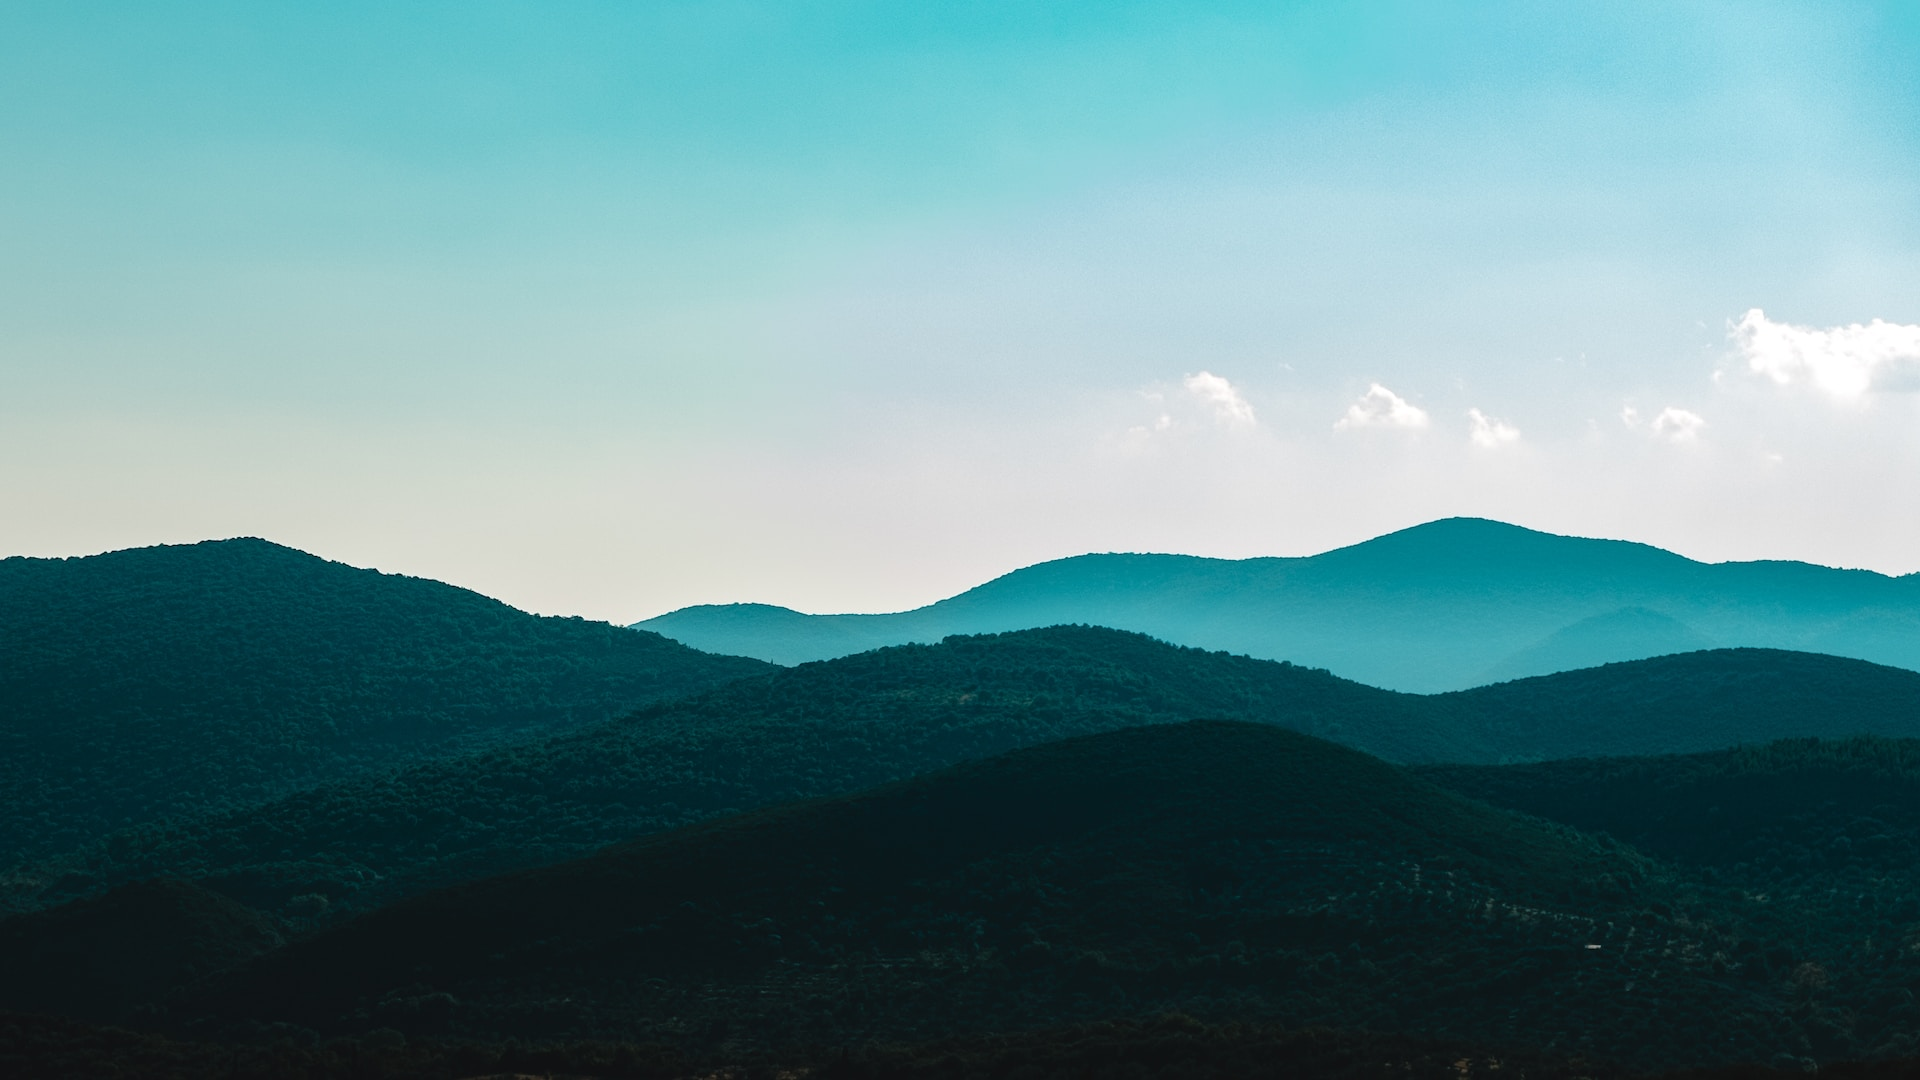
Image conveying a sense of tranquility (<a href="https://unsplash.com/photos/landscape-photography-of-green-mountain-8wz1Q4Q_XAg">photo by Billy Williams on Unsplash</a>).

# Constants



*   **`HADOOP_VERSION`** This is the Hadoop version we want to use. Here we chose `3.3.6`, the last version preceeding the current stable version (`3.4.0` as of March 17th, 2024). If you want to upgrade the Hadoop version in this notebook, edit the variable `HADOOP_VERSION` in the code below. To find out what the latest stable version is, check https://hadoop.apache.org/releases.html.

*   **`HADOOP_URL`** this is the URL where we download Hadoop from. We are going to download the Apache core Hadoop distribution from https://dlcdn.apache.org/hadoop/. Other Hadoop distributions are available from the [Bigtop project](https://bigtop.apache.org/). Older Hadoop versions can be found in https://archive.apache.org/dist/hadoop/core/.

*   **`LOGGING_LEVEL`** is used by the logging library that will be used throughout the notebook to document each step. This is *not* the Hadoop log lever that needs to be configured somewhere else. The `#@param` expression in the code allows to select from a dropdown interactively with a widget provided by [Google Colab forms](https://colab.research.google.com/notebooks/forms.ipynb).


In [1]:
# Hadoop version
HADOOP_VERSION = "3.3.6"
# URL for downloading Hadoop
HADOOP_URL = f"https://dlcdn.apache.org/hadoop/common/hadoop-{HADOOP_VERSION}/hadoop-{HADOOP_VERSION}.tar.gz"

# logging level (should be one of: DEBUG, INFO, WARNING, ERROR, CRITICAL)
LOGGING_LEVEL = "INFO" #@param ["DEBUG", "INFO", "WARNING", "ERROR", "CRITICAL"]


# Imports

Some Python libraries are needed for setting up and operating the Hadoop engine while others will be used for the tutorial:

*   `urllib.request` and `tarfile` to download and unpack the Hadoop distribution file.
*   `logging` to log each step in this notebook
*   `subprocess` to start processes without blocking notebook cells
*   `ssh_utilities` is required by the Hadoop daemons and if I remember correctly `Crypto` and `pycryptodome` are required for the correct functioning of `ssh_utilities`


In [2]:
import sys
import logging
import subprocess
import os

!pip install Crypto
!pip install pycryptodome
import Crypto

!pip install ssh_utilities
from ssh_utilities import Connection

import shutil
from pathlib import Path
import urllib.request
import tarfile
import xml.etree.ElementTree as ET
import xml.dom.minidom
import glob

# true if running on Google Colab
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
 from google.colab import output

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.9/225.9 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 39.8 MB/s eta 0:00:00


# Setup logging

In [3]:
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging_level = getattr(logging, LOGGING_LEVEL.upper(), 10)

logging.basicConfig(level=logging_level, \
                    format='%(asctime)s - %(levelname)s: %(message)s', \
                    datefmt='%d-%b-%y %I:%M:%S %p')

logger = logging.getLogger('my_logger')

# Set `JAVA_HOME`

Java $8$ or $11$ is required for Hadoop $3.*$ (see [Hadoop Java Versions](https://cwiki.apache.org/confluence/display/HADOOP/Hadoop+Java+Versions)).

Java $11$ is available on Google Colab but we accomodate for the general case of an Ubuntu machine where Java (here we chose the `openjdk-19-jre-headless` version) needs to be installed.

In [4]:
# set variable JAVA_HOME (install Java if necessary)
def is_java_installed():
    os.environ['JAVA_HOME'] = os.path.realpath(shutil.which("java")).split('/bin')[0]
    return os.environ['JAVA_HOME']

def install_java():
    # Uncomment and modify the desired version
    # java_version= 'openjdk-11-jre-headless'
    # java_version= 'default-jre'
    # java_version= 'openjdk-17-jre-headless'
    # java_version= 'openjdk-18-jre-headless'
    java_version= 'openjdk-19-jre-headless'

    print(f"Java not found. Installing {java_version} ... (this might take a while)")
    try:
        cmd = f"apt install -y {java_version}"
        subprocess_output = subprocess.run(cmd, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
        stdout_result = subprocess_output.stdout
        # Process the results as needed
        logger.info("Done installing Java {}".format(java_version))
        os.environ['JAVA_HOME'] = os.path.realpath(shutil.which("java")).split('/bin')[0]
        logger.info("JAVA_HOME is {}".format(os.environ['JAVA_HOME']))
    except subprocess.CalledProcessError as e:
        # Handle the error if the command returns a non-zero exit code
        logger.warn("Command failed with return code {}".format(e.returncode))
        logger.warn("stdout: {}".format(e.stdout))

# Install Java if not available
if is_java_installed():
    logger.info("Java is already installed")
    logger.info("JAVA_HOME is {}".format(os.environ['JAVA_HOME']))
else:
    logger.info("Installing Java")
    install_java()

04-Aug-24 09:28:03 PM - INFO: Java is already installed
04-Aug-24 09:28:03 PM - INFO: JAVA_HOME is /usr/lib/jvm/java-11-openjdk-amd64


# Start `sshd` server

The Hadoop cluster needs `ssh` for communication (even if it runs on a single node). See the official documentation: [Setup passphraseless ssh](https://hadoop.apache.org/docs/stable/hadoop-project-dist/hadoop-common/SingleCluster.html#Setup_passphraseless_ssh).

We install `openssh-server` and test if the installation was successful with the shell command

    ssh localhost "echo hi!"

as well as using `Connection` from the Python's `ssh_utilities` library.

## Install `openssh-server`

In [5]:
logger.info("Installing {}".format("openssh-server"))
cmd = ["apt-get", "install", "openssh-server"]
try:
    result = subprocess.check_output(cmd, stderr=subprocess.STDOUT, text=True)
except subprocess.CalledProcessError as e:
    # Access the error message from the output attribute
    error_message = e.output
    print(f"Command failed with error message: {error_message}")

04-Aug-24 09:28:03 PM - INFO: Installing openssh-server


## Configure `sshd` service

In [6]:
if IN_COLAB:
  ssh_config_file = "/etc/ssh/ssh_config"
  with open(ssh_config_file, "r+") as f:
    var = 'StrictHostKeyChecking no'
    line_found = any(line.strip().startswith(var) for line in f)
    if not line_found:
      f.seek(0, os.SEEK_END)
      f.write(var +"\n")

## Start `sshd` service

In [7]:
logger.info("Starting {}".format("openssh-server"))
cmd = ["/etc/init.d/ssh", "restart"]
try:
    result = subprocess.check_output(cmd, stderr=subprocess.STDOUT, text=True)
except subprocess.CalledProcessError as e:
    # Access the error message from the output attribute
    error_message = e.output
    print(f"Command failed with error message: {error_message}")


04-Aug-24 09:28:22 PM - INFO: Starting openssh-server


## Create private/public key

The private/public key pair is needed for passwordless authentication.

Note: for some reason `Crypto` doesn't work without `pycryptodome` (see [ModuleNotFoundError: No module named 'Crypto' Error](https://stackoverflow.com/questions/51824628/modulenotfounderror-no-module-named-crypto-error)).

In [8]:
from Crypto.PublicKey import RSA
key = RSA.generate(2048)
if not os.path.exists(os.path.join(os.path.expanduser('~'), '.ssh')):
  os.makedirs(os.path.join(os.path.expanduser('~'), '.ssh'), mode=700)
#os.chmod(os.path.join(os.path.expanduser('~'),'.ssh'), int('700', base=8))

with open(os.path.join(os.path.expanduser('~'), '.ssh/id_rsa'), 'wb') as f:
  os.chmod(os.path.join(os.path.expanduser('~'),'.ssh/id_rsa'), int('0600', base=8))
  f.write(key.export_key('PEM', passphrase=None))
pubkey = key.publickey()

with open(os.path.join(os.path.expanduser('~'), '.ssh/id_rsa.pub'), 'wb') as f:
    f.write(pubkey.exportKey('OpenSSH'))

In [9]:
with open(os.path.join(os.path.expanduser('~'), '.ssh/authorized_keys'), 'w') as a:
  with open(os.path.join(os.path.expanduser('~'),'.ssh/id_rsa.pub'), 'r') as f:
    a.write(f.read())
  os.chmod(os.path.join(os.path.expanduser('~'), '.ssh/authorized_keys'), int('600', base=8))


## Test `ssh` connection

We are going to test if the passphraseless connection is working by running the command `"echo hi!"` on `localhost` over `ssh`. The output should be `'hi!'` if the `ssh` connection is working.

**1. Test with a shell command**

In [10]:
!ssh localhost "echo hi!"

hi!


**2. Test with Python `ssh_utilities.Connection`**

In [11]:
private_key = os.path.join(os.path.expanduser('~'), '.ssh/id_rsa')
conn = Connection.open('root','localhost', private_key)

try:
    command_output = conn.subprocess.run(['echo', 'hi!'], suppress_out=True, quiet=False,
                          capture_output=True, check=True, cwd=Path('/content'))
except Exception as err:
    logger.error(err)
    print("❌ An exception occurred:")
    print(err)
else:
    logger.info("Successfully executed command on localhost over ssh")
    print("✅ Successfully executed command {} on localhost".format('"ssh localhost \'echo hi!\'"'))
    print("Stdout: {}".format(command_output.stdout.decode("utf-8")))

04-Aug-24 09:28:24 PM - INFO: Connection object will not be thread safe


Will login with private RSA key located in /root/.ssh/id_rsa


04-Aug-24 09:28:24 PM - INFO: Will login with private RSA key located in /root/.ssh/id_rsa


Connecting to server: root@localhost


04-Aug-24 09:28:24 PM - INFO: Connecting to server: root@localhost


When running an executale on server always make sure that full path is specified!!!



04-Aug-24 09:28:24 PM - INFO: When running an executale on server always make sure that full path is specified!!!

04-Aug-24 09:28:24 PM - INFO: could not parse key with Ed25519Key
04-Aug-24 09:28:24 PM - INFO: could not parse key with DSSKey
04-Aug-24 09:28:24 PM - INFO: could not parse key with ECDSAKey
04-Aug-24 09:28:24 PM - INFO: trying to authenticate with private-key
04-Aug-24 09:28:24 PM - INFO: Connected (version 2.0, client OpenSSH_8.9p1)
04-Aug-24 09:28:24 PM - INFO: Authentication (publickey) successful!
04-Aug-24 09:28:24 PM - INFO: successfully authenticated with: private-key


Executing command on remote: echo hi!



04-Aug-24 09:28:24 PM - INFO: Successfully executed command on localhost over ssh


✅ Successfully executed command "ssh localhost 'echo hi!'" on localhost
Stdout: 


# Setup Hadoop


## Download core Hadoop
Download the latest stable version of the core Hadoop distribution from one of the download mirrors locations https://www.apache.org/dyn/closer.cgi/hadoop/common/.

In [12]:
file_name = os.path.basename(HADOOP_URL)
if os.path.isfile(file_name):
   logger.info("{} already exists, not downloading".format(file_name))
else:
  logger.info("Downloading {}".format(file_name))
  urllib.request.urlretrieve(HADOOP_URL, file_name)

04-Aug-24 09:28:25 PM - INFO: Downloading hadoop-3.3.6.tar.gz


## Uncompress archive

In [13]:
dir_name = file_name[:-7]
if os.path.exists(dir_name):
  logger.info("{} is already uncompressed".format(file_name))
else:
  logger.info("Uncompressing {}".format(file_name))
  tar = tarfile.open(file_name)
  tar.extractall()
  tar.close()

04-Aug-24 09:28:31 PM - INFO: Uncompressing hadoop-3.3.6.tar.gz


## Configure Hadoop

In this section we continue following Apache Hadoop's official documentation on how to set up a single node in pseudo-distributed mode (see [Configuration](https://hadoop.apache.org/docs/stable/hadoop-project-dist/hadoop-common/SingleCluster.html#Configuration)).


### Environment variables

In [14]:
os.environ['HADOOP_HOME'] = os.path.join(os.path.join(os.getcwd(), dir_name))
logger.info("HADOOP_HOME is {}".format(os.environ['HADOOP_HOME']))

os.environ['HADOOP_COMMON_HOME'] = os.environ['HADOOP_HOME']
logger.info("HADOOP_COMMON_HOME is {}".format(os.environ['HADOOP_COMMON_HOME']))

os.environ['HADOOP_MAPREDUCE_HOME'] = os.environ['HADOOP_HOME']
logger.info("HADOOP_MAPREDUCE_HOME is {}".format(os.environ['HADOOP_MAPREDUCE_HOME']))

os.environ['HADOOP_YARN_HOME'] = os.environ['HADOOP_HOME']
logger.info("HADOOP_YARN_HOME is {}".format(os.environ['HADOOP_YARN_HOME']))

os.environ['PATH'] = ':'.join([os.path.join(os.environ['HADOOP_HOME'], 'bin'), os.environ['PATH']])
logger.info("PATH is {}".format(os.environ['PATH']))

os.environ['HADOOP_VERSION'] = HADOOP_VERSION
logger.info("HADOOP_VERSION is {}".format(os.environ['HADOOP_VERSION']))

04-Aug-24 09:28:53 PM - INFO: HADOOP_HOME is /content/hadoop-3.3.6
04-Aug-24 09:28:53 PM - INFO: HADOOP_COMMON_HOME is /content/hadoop-3.3.6
04-Aug-24 09:28:53 PM - INFO: HADOOP_MAPREDUCE_HOME is /content/hadoop-3.3.6
04-Aug-24 09:28:53 PM - INFO: HADOOP_YARN_HOME is /content/hadoop-3.3.6
04-Aug-24 09:28:53 PM - INFO: PATH is /content/hadoop-3.3.6/bin:/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin
04-Aug-24 09:28:53 PM - INFO: HADOOP_VERSION is 3.3.6


### Hadoop configuration files

Throughout this notebook we're going to edit four important Hadoop configuration files:


*   `core-site.xml` containing the *site-specific configuration* of the Hadoop core
*   `hdfs-site.xml` containing the *site-specific configuration* of Hadoop's HDFS
*   `yarn-site.xml` containing the *site-specific configuration* of Hadoop's YARN
*   `mapred-site.xml` containing the *site-specific configuration* of Hadoop's MapReduce

Additionally, we are going to edit the file `hadoop-env.sh`, a helper file containing environment variables needed by the shell scripts used to start the cluster.

All these files can be found in `etc/hadoop` under `$HADOOP_HOME` (the Hadoop installation folder).

In [15]:
# site-specific configuration files
core_site_file = os.path.join(os.environ['HADOOP_HOME'],'etc/hadoop/core-site.xml')
hdfs_site_file = os.path.join(os.environ['HADOOP_HOME'],'etc/hadoop/hdfs-site.xml')
yarn_site_file = os.path.join(os.environ['HADOOP_HOME'],'etc/hadoop/yarn-site.xml')
mapred_site_file = os.path.join(os.environ['HADOOP_HOME'],'etc/hadoop/mapred-site.xml')

# Hadoop environment variables
hadoop_env_file = os.path.join(os.environ['HADOOP_HOME'],'etc/hadoop/hadoop-env.sh')

Here's all the configuration files:

In [16]:
!ls $HADOOP_HOME/etc/hadoop/*xml $HADOOP_HOME/etc/hadoop/hadoop-env.sh

/content/hadoop-3.3.6/etc/hadoop/capacity-scheduler.xml
/content/hadoop-3.3.6/etc/hadoop/core-site.xml
/content/hadoop-3.3.6/etc/hadoop/hadoop-env.sh
/content/hadoop-3.3.6/etc/hadoop/hadoop-policy.xml
/content/hadoop-3.3.6/etc/hadoop/hdfs-rbf-site.xml
/content/hadoop-3.3.6/etc/hadoop/hdfs-site.xml
/content/hadoop-3.3.6/etc/hadoop/httpfs-site.xml
/content/hadoop-3.3.6/etc/hadoop/kms-acls.xml
/content/hadoop-3.3.6/etc/hadoop/kms-site.xml
/content/hadoop-3.3.6/etc/hadoop/mapred-site.xml
/content/hadoop-3.3.6/etc/hadoop/yarn-site.xml


### Functions for editing Hadoop configuration files

In order to edit the site-specific configuration files in an orderly fashion, we have created the functions:

*   `clear_conf_file(file)` to remove all properties from the XML file `file`
*   `edit_conf_file(file, propertyname, propertyvalue)` to add property name and value in the proper format to the XML file `file`
*   `print_conf_file(file)` to pretty-print the XML file `file`

In [17]:
def clear_conf_file(file):
  tree = ET.parse(file)
  root = tree.getroot()
  # remove all properties
  for el in list(root):
     root.remove(el)
  tree.write(file, encoding='utf-8', xml_declaration=True)
  # pretty-print
  dom = xml.dom.minidom.parse(file)

def edit_conf_file(file, propertyname, propertyvalue):
  tree = ET.parse(file)
  root = tree.getroot()
  logger.info("add property {} to {}".format(propertyname, file))
  property = ET.SubElement(root, 'property')
  name = ET.SubElement(property, 'name')
  name.text = propertyname
  value = ET.SubElement(property, 'value')
  value.text = propertyvalue
  tree.write(file, encoding='utf-8', xml_declaration=True)

def print_conf_file(file):
  # pretty-print
  dom = xml.dom.minidom.parse(file)
  print(dom.toprettyxml())

### Edit `core-site.xml` and `hdfs-site.xml`

Let us configure two properties:

*   `fs.defaultFS` (the URI of the default file system) to `hdfs://localhost:9000` in `core-site.xml`
*   `dfs.replication` to $1$ (the default is $3$) in `hdfs-site.xml`

In [18]:
clear_conf_file(core_site_file)
edit_conf_file(core_site_file, 'fs.defaultFS', 'hdfs://localhost:9000')
print_conf_file(core_site_file)

04-Aug-24 09:28:53 PM - INFO: add property fs.defaultFS to /content/hadoop-3.3.6/etc/hadoop/core-site.xml


<?xml version="1.0" ?>
<configuration>
	

	<property>
		<name>fs.defaultFS</name>
		<value>hdfs://localhost:9000</value>
	</property>
</configuration>



In [19]:
clear_conf_file(hdfs_site_file)
edit_conf_file(hdfs_site_file, 'dfs.replication', '1')
print_conf_file(hdfs_site_file)

04-Aug-24 09:28:53 PM - INFO: add property dfs.replication to /content/hadoop-3.3.6/etc/hadoop/hdfs-site.xml


<?xml version="1.0" ?>
<configuration>
	


	<property>
		<name>dfs.replication</name>
		<value>1</value>
	</property>
</configuration>



### Hadoop's default configuration files

By providing site-specific configuration files one can override any of the default properties. The default values files corresponding to the site-specific files are:

*  `core-default.xml`
*  `hdfs-default.xml`
*  `yarn-default.xml`
*  `mapred-default.xml`

These are read-only files that contain all default values for Hadoop properties (see [cluster setup](https://hadoop.apache.org/docs/stable/hadoop-project-dist/hadoop-common/ClusterSetup.html#Configuring_Hadoop_in_Non-Secure_Mode)) and can be viewed at:


In [20]:
list(glob.iglob(os.environ['HADOOP_HOME']+ '/**/*default.xml', recursive=True))

['/content/hadoop-3.3.6/share/doc/hadoop/hadoop-project-dist/hadoop-hdfs-rbf/hdfs-rbf-default.xml',
 '/content/hadoop-3.3.6/share/doc/hadoop/hadoop-project-dist/hadoop-hdfs/hdfs-default.xml',
 '/content/hadoop-3.3.6/share/doc/hadoop/hadoop-project-dist/hadoop-common/core-default.xml',
 '/content/hadoop-3.3.6/share/doc/hadoop/hadoop-yarn/hadoop-yarn-common/yarn-default.xml',
 '/content/hadoop-3.3.6/share/doc/hadoop/hadoop-mapreduce-client/hadoop-mapreduce-client-core/mapred-default.xml']

In [21]:
print('\n'.join([core_site_file, hdfs_site_file, yarn_site_file, mapred_site_file]))

/content/hadoop-3.3.6/etc/hadoop/core-site.xml
/content/hadoop-3.3.6/etc/hadoop/hdfs-site.xml
/content/hadoop-3.3.6/etc/hadoop/yarn-site.xml
/content/hadoop-3.3.6/etc/hadoop/mapred-site.xml


The default values for Hadoop properties (`*-default.xml` files) can also be found online ([core-default.xml](https://hadoop.apache.org/docs/r3.3.6/hadoop-project-dist/hadoop-common/core-default.xml), [hdfs-default](https://hadoop.apache.org/docs/r3.3.6/hadoop-project-dist/hadoop-hdfs/hdfs-default.xml), [yarn-default.xml](https://hadoop.apache.org/docs/r3.3.6/hadoop-yarn/hadoop-yarn-common/yarn-default.xml), [mapred-default.xml](https://hadoop.apache.org/docs/r3.3.6/hadoop-mapreduce-client/hadoop-mapreduce-client-core/mapred-default.xml).

Just make sure you get the correct version by googling for instance:

> "core-default.xml" stable

or

> "core-default.xml" r3.3.6

### View configuration values with `hdfs -getconf`

Properties that are not configured in the `*-site.xml` files get the default values from the `*-default.xml` files.

You can examine configuration values with the command [`hdfs -getconf -confKey`](https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-hdfs/HDFSCommands.html#getconf).

Let us check the keys we just configured.

In [22]:
!hdfs getconf -confKey fs.defaultFS

hdfs://localhost:9000


In [23]:
!hdfs getconf -confKey dfs.replication

1


What is the default value of `dfs.blocksize` (the block size for the distributed filesystem)?

In [24]:
!hdfs getconf -confKey dfs.blocksize

134217728


Show size in human-readable format

In [25]:
!hdfs getconf -confKey dfs.blocksize| numfmt --to=iec 2>/dev/null

128M


### Edit `hadoop-env.sh`

In the configuration script `hadoop-env.sh` we want to define `root` as the  user starting all services since we are not bothering to define other users in this tutorial (see also [https://hadoop.apache.org/docs/stable/hadoop-project-dist/hadoop-common/UnixShellGuide.html#a.28command.29_.28subcommand.29_USER]).

I suspect that setting `JAVA_HOME` is not necessary at this point since it is already in the environment but it won't hurt.

In [26]:
users = ['HDFS_NAMENODE_USER', \
         'HDFS_DATANODE_USER', \
         'HDFS_SECONDARYNAMENODE_USER', \
         'YARN_RESOURCEMANAGER_USER', \
         'YARN_NODEMANAGER_USER', \
         'YARN_PROXYSERVER_USER']

logger.info("Editing {}".format(hadoop_env_file))

with open(hadoop_env_file, "r+") as f:
  for u in users:
    var = 'export ' + u + '=root'
    line_found = any(line.startswith(var) for line in f)
    if not line_found:
      f.seek(0, os.SEEK_END)
      f.write(var +"\n")
  line_found = any(line.startswith('export JAVA_HOME=') for line in f)
  if not line_found:
      f.seek(0, os.SEEK_END)
      f.write('export JAVA_HOME='+os.environ['JAVA_HOME']+"\n")

04-Aug-24 09:29:03 PM - INFO: Editing /content/hadoop-3.3.6/etc/hadoop/hadoop-env.sh


### Display computed Hadoop environment variables

In [27]:
!hdfs envvars

JAVA_HOME='/usr/lib/jvm/java-11-openjdk-amd64'
HADOOP_HDFS_HOME='/content/hadoop-3.3.6'
HDFS_DIR='share/hadoop/hdfs'
HDFS_LIB_JARS_DIR='share/hadoop/hdfs/lib'
HADOOP_CONF_DIR='/content/hadoop-3.3.6/etc/hadoop'
HADOOP_TOOLS_HOME='/content/hadoop-3.3.6'
HADOOP_TOOLS_DIR='share/hadoop/tools'
HADOOP_TOOLS_LIB_JARS_DIR='share/hadoop/tools/lib'


## Initialize the namenode

Formatting the namenode will overwrite the Hadoop filesystem. In a production setting, this step should be executed only once at initial setup.

In [28]:
logger.info("Formatting NameNode")
cmd = ["hdfs", "namenode", "-format", "-nonInteractive"]
result = subprocess.call(cmd, stderr=subprocess.STDOUT)

04-Aug-24 09:29:03 PM - INFO: Formatting NameNode


# Start HDFS

Launch a single-node HDFS cluster with the command `start-dfs.sh`. This will start namenodes and datanodes as separate Java processes.

In [29]:
subprocess_output = subprocess.run([os.path.join(os.environ['HADOOP_HOME'], 'sbin', 'start-dfs.sh')], check=True, stdout=subprocess.PIPE)
print(subprocess_output.stdout.decode())

Starting namenodes on [localhost]
Starting datanodes
Starting secondary namenodes [ced9dfeb9431]
ced9dfeb9431: Warning: Permanently added 'ced9dfeb9431' (ED25519) to the list of known hosts.



# HDFS processes and ports

We have started some Java virtual machines corresponding to different Hadoop services. By using `lsof` to show listening ports you should get something like this:
```
COMMAND   PID USER   FD   TYPE DEVICE SIZE/OFF NODE NAME
java    13177 root  341u  IPv4 357089      0t0  TCP *:9870 (LISTEN)
java    13177 root  349u  IPv4 358597      0t0  TCP 127.0.0.1:9000 (LISTEN)
java    13297 root  342u  IPv4 359615      0t0  TCP *:9866 (LISTEN)
java    13297 root  345u  IPv4 358674      0t0  TCP 127.0.0.1:40349 (LISTEN)
java    13297 root  374u  IPv4 358786      0t0  TCP *:9864 (LISTEN)
java    13297 root  375u  IPv4 358790      0t0  TCP *:9867 (LISTEN)
java    13515 root  343u  IPv4 360840      0t0  TCP *:9868 (LISTEN)
```

In [30]:
!lsof -n -i -P +c0 -sTCP:LISTEN -ac java

COMMAND  PID USER   FD   TYPE DEVICE SIZE/OFF NODE NAME
java    2085 root  341u  IPv4  65913      0t0  TCP *:9870 (LISTEN)
java    2085 root  349u  IPv4  67634      0t0  TCP 127.0.0.1:9000 (LISTEN)
java    2190 root  342u  IPv4  66815      0t0  TCP *:9866 (LISTEN)
java    2190 root  345u  IPv4  67292      0t0  TCP 127.0.0.1:35485 (LISTEN)
java    2190 root  374u  IPv4  68044      0t0  TCP *:9864 (LISTEN)
java    2190 root  375u  IPv4  67490      0t0  TCP *:9867 (LISTEN)
java    2417 root  343u  IPv4  69545      0t0  TCP *:9868 (LISTEN)


As you can see, we have multiple services running on different ports all spawned by different Java processes corresponding to:


*   NameNode
*   DataNode
*   Secondary NameNode




port number | description | configured in
--- | --- | --- |
9870 | dfs.namenode.http-address | [hdfs-default.xml](https://hadoop.apache.org/docs/r3.0.0/hadoop-project-dist/hadoop-hdfs/hdfs-default.xml) |
9000 | fs.defaultFS | as defined in `core-site.xml` |
9864 | dfs.datanode.http.address | [hdfs-default.xml](https://hadoop.apache.org/docs/r3.0.0/hadoop-project-dist/hadoop-hdfs/hdfs-default.xml) |
9866 | dfs.datanode.address| [hdfs-default.xml](https://hadoop.apache.org/docs/r3.0.0/hadoop-project-dist/hadoop-hdfs/hdfs-default.xml) |
9867 | dfs.datanode.ipc.address | [hdfs-default.xml](https://hadoop.apache.org/docs/r3.0.0/hadoop-project-dist/hadoop-hdfs/hdfs-default.xml) |
9868 | dfs.namenode.secondary.http-address | [hdfs-default.xml](https://hadoop.apache.org/docs/r3.0.0/hadoop-project-dist/hadoop-hdfs/hdfs-default.xml) |


## Check if HDFS is up and running

Once HDFS is up and running there should be a total of $7$ `java` listening ports and six of them are precisely ports $9870$, $9000$, $9864$, $9866$, $9876$, $9868$.

Let us check if this is the case introducing a cycle of 20 retries (one per second) to check if all the required ports are available. This check is needed for non-interactive runs of the notebook.

In [31]:
%%bash
counter=0
until [ $counter -gt 20 ]
do
  ((counter++))
  sleep 1
  # counting lines, exclude header and jupyter port 9000
  if [ $(lsof -n -i -P +c0 -sTCP:LISTEN -ac java| wc -l ) -ge 8 ] && \
  [ $(lsof -n -aiTCP:9870 -aiTCP:9000 -aiTCP:9864 -aiTCP:9866 -aiTCP:9867 -aiTCP:9868 -P +c0 -sTCP:LISTEN -ac java | wc -l) -eq 7 ]
  then
   echo "HDFS is up and running"
   echo "Time elapsed: $counter secs"
   exit
  fi
done
echo "Some HDFS ports are missing. Wait some more or restart HDFS."

HDFS is up and running
Time elapsed: 1 secs


## `lsof` for viewing listening ports

`lsof` is an exceptionally valuable command. With the option `-i` it can be used to show processes listening to network connections.

An example: check for `java` listening to a specific port ($9864$)

In [32]:
!lsof -iTCP:9864 -n -P +c0 -sTCP:LISTEN -ac java

COMMAND  PID USER   FD   TYPE DEVICE SIZE/OFF NODE NAME
java    2190 root  374u  IPv4  68044      0t0  TCP *:9864 (LISTEN)


### Options used in `lsof`:

* `-i` specifies that you want to display only network files, that is open network connections
* `-n` and `-P` tell `lsof` to show ports and IP addresses in numeric form
* the option `+c0` is used to show a longer substring of the name of the UNIX command associated with the process (https://linux.die.net/man/8/lsof)
* `-sTCP:LISTEN` filters for TCP connections in state `LISTEN`



# Check the NameNode

## On the command-line

Run the command `hdfs dfsadmin -report`.

In [33]:
subprocess_output = subprocess.run([os.path.join(os.environ['HADOOP_HOME'], 'bin', 'hdfs'), 'dfsadmin', '-report'], check=True, stdout=subprocess.PIPE)
print(subprocess_output.stdout.decode())

Configured Capacity: 115658190848 (107.72 GB)
Present Capacity: 80370434048 (74.85 GB)
DFS Remaining: 80370409472 (74.85 GB)
DFS Used: 24576 (24 KB)
DFS Used%: 0.00%
Replicated Blocks:
	Under replicated blocks: 0
	Blocks with corrupt replicas: 0
	Missing blocks: 0
	Missing blocks (with replication factor 1): 0
	Low redundancy blocks with highest priority to recover: 0
	Pending deletion blocks: 0
Erasure Coded Block Groups: 
	Low redundancy block groups: 0
	Block groups with corrupt internal blocks: 0
	Missing block groups: 0
	Low redundancy blocks with highest priority to recover: 0
	Pending deletion blocks: 0

-------------------------------------------------
Live datanodes (1):

Name: 127.0.0.1:9866 (localhost)
Hostname: ced9dfeb9431
Decommission Status : Normal
Configured Capacity: 115658190848 (107.72 GB)
DFS Used: 24576 (24 KB)
Non DFS Used: 35270979584 (32.85 GB)
DFS Remaining: 80370409472 (74.85 GB)
DFS Used%: 0.00%
DFS Remaining%: 69.49%
Configured Cache Capacity: 0 (0 B)
Cache

## In the Web UI

The namenode runs a Web interface displaying information about the current status of the cluster (see [HdfsUserGuide.html#Web_Interface](https://hadoop.apache.org/docs/stable/hadoop-project-dist/hadoop-hdfs/HdfsUserGuide.html#Web_Interface)). By default, the dfs namenode Web UI listens on port $9870$.

Let us open the Web UI in another tab in the browser with Google Colab's `output` library (source: https://github.com/googlecolab/colabtools/tree/main/google/colab/output, documentation: [Browsing to servers executing on the kernel](https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=95mvP1VeYETf)).

### Serve the NameNode Web UI with Colab `output`

**Note:** In the free tier of Google Colab this functionality might not be available (see https://research.google.com/colaboratory/faq.html#limitations-and-restrictions). As an alternative, you can use ngrok after signing up for a free account (see the [next section](https://colab.research.google.com/github/groda/big_data/blob/master/Hadoop_single_node_cluster_setup_Python.ipynb#scrollTo=Serve_the_NameNode_Web_UI_with_ngrok)).

In [34]:
!wget localhost:9870

--2024-08-04 21:29:41--  http://localhost:9870/
Resolving localhost (localhost)... 127.0.0.1, ::1
Connecting to localhost (localhost)|127.0.0.1|:9870... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://localhost:9870/index.html [following]
--2024-08-04 21:29:41--  http://localhost:9870/index.html
Reusing existing connection to localhost:9870.
HTTP request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [text/html]
Saving to: ‘index.html’

index.html          100%[===================>]   1.05K  --.-KB/s    in 0s      

2024-08-04 21:29:41 (114 MB/s) - ‘index.html’ saved [1079/1079]



In [35]:
%%capture namenode_url
if IN_COLAB:
  port = 9870
  output.serve_kernel_port_as_window(port, path='/index.html')

In [36]:
if IN_COLAB:
  namenode_url.show()

<IPython.core.display.Javascript object>

This is what you should see if you open the above link in a newly opened tab or window in your browser
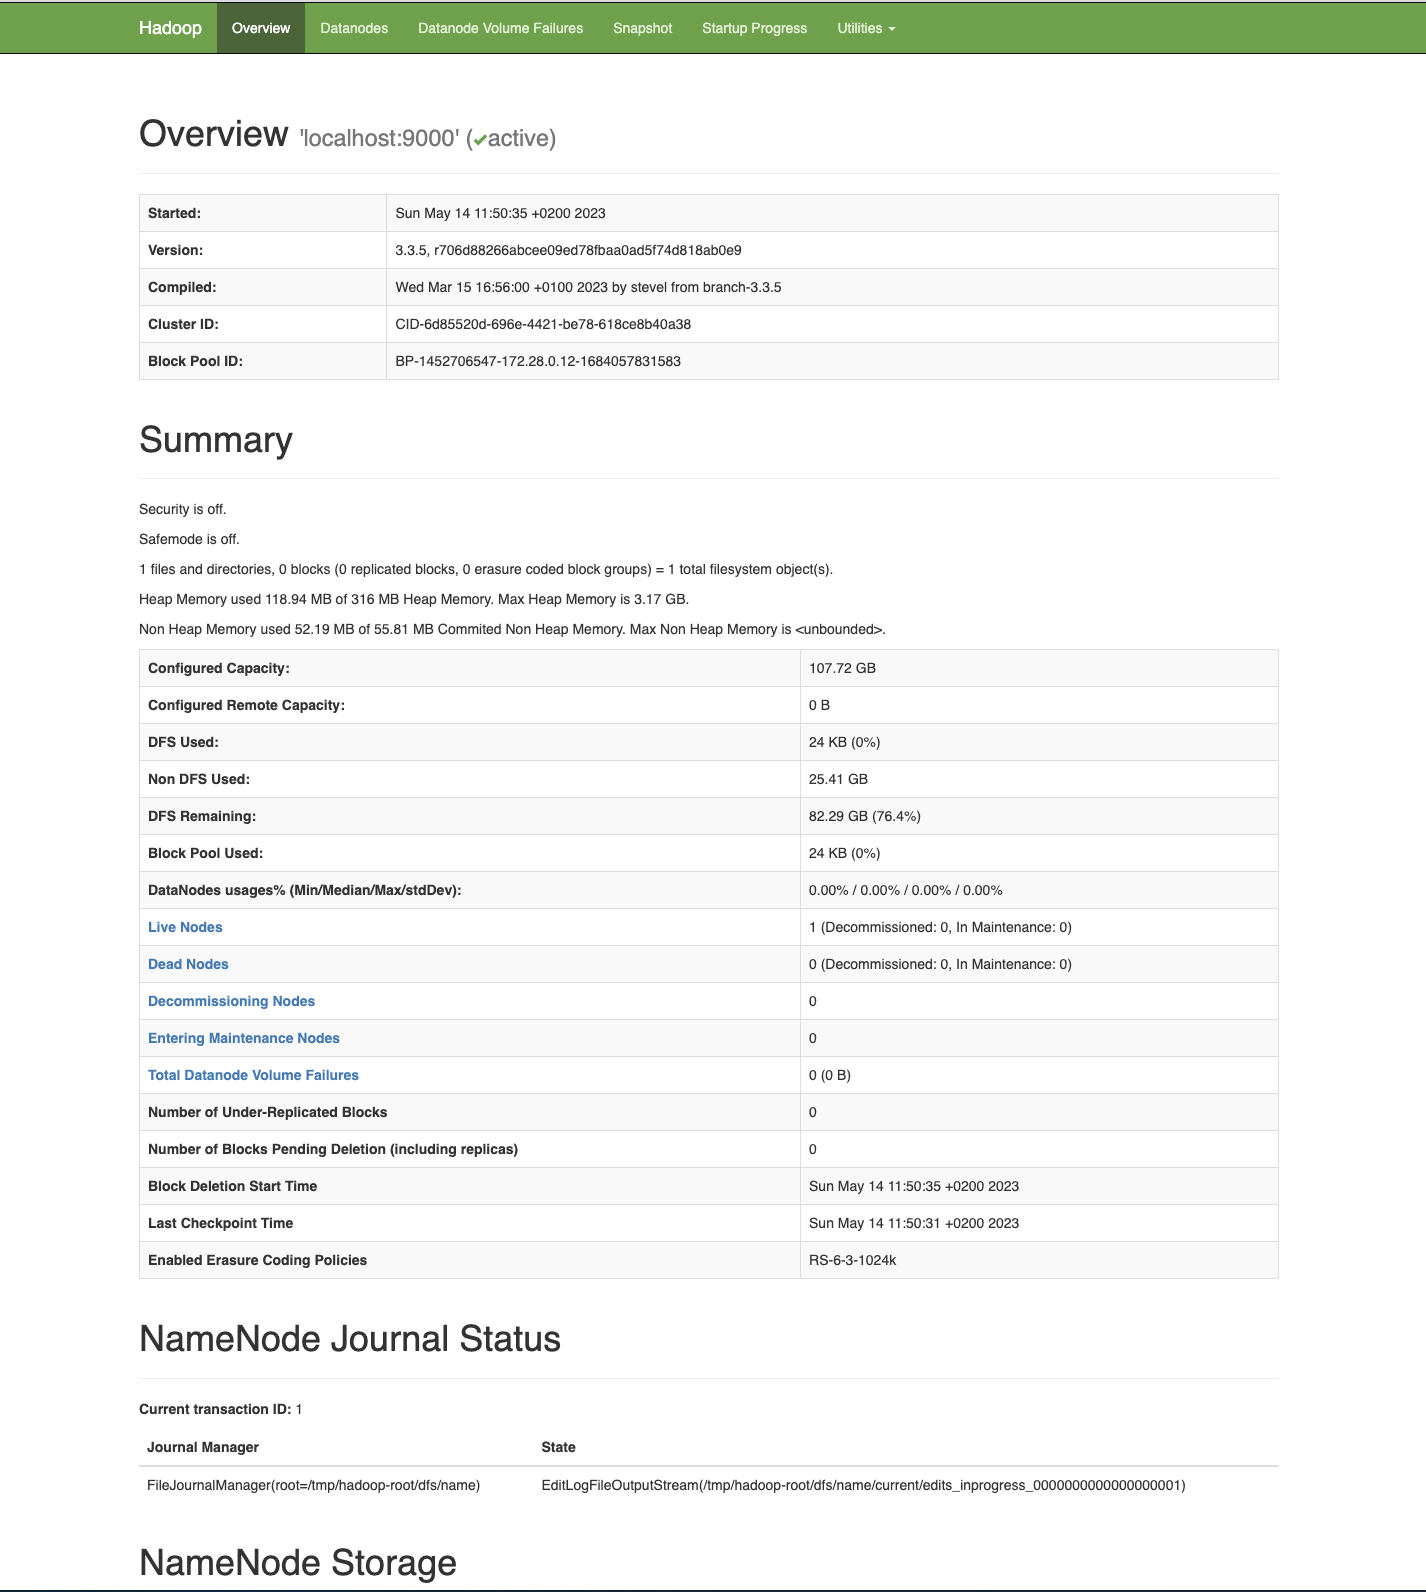

On port $9864$ you can access the datanode's Web UI.

In [ ]:
%%capture datanode_url
if IN_COLAB:
  port = 9864
  output.serve_kernel_port_as_window(port, path='/index.html')

In [ ]:
if IN_COLAB:
  datanode_url.show()

<IPython.core.display.Javascript object>

#### A note on Google Colaboratory advanced outputs

Throughout this notebook, I use the function `output.serve_kernel_port_as_window` to serve Web pages from Google Colab.

You can find the documentation for Google Colab's advanced outputs library at: https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=Browsing_to_servers_executing_on_the_kernel.

Before serving a link, I always use `wget` to see if there are any redirections that need to be included in the `path` option. For instance:

    output.serve_kernel_port_as_window(9870, path='/index.html')

works but

    output.serve_kernel_port_as_window(9870)

will not work!

Oddly, the function `output.serve_kernel_port_as_window` is deprecated in favor of `serve_kernel_port_as_iframe`, which does not work.

In [ ]:
if IN_COLAB:
  help(output.serve_kernel_port_as_window)

Help on function serve_kernel_port_as_window in module google.colab.output._util:

serve_kernel_port_as_window(port, path='/', anchor_text=None)
    Displays a link in the output to open a browser tab to a port on the kernel.
    
    DEPRECATED; Browser security updates have broken this feature. Use
    `serve_kernel_port_as_iframe` instead. See
    https://developer.chrome.com/en/docs/privacy-sandbox/storage-partitioning/.
    
    
    This allows viewing URLs hosted on the kernel in new browser tabs.
    
    The URL will only be valid for the current user while the notebook is open in
    Colab.
    
    Args:
      port: The kernel port to be exposed to the client.
      path: The path to be navigated to.
      anchor_text: Text content of the anchor link.



### Serve the NameNode Web UI with ngrok

In order to use [ngrok](https://ngrok.com/), you need to create a free account and check the NGROK box below if you want to use ngrok.

In [37]:
# you should set this to True
NGROK = False #@param {type:"boolean"}

We are going to use the Python ngrok client `pyngrok` (see the [Colab example](https://pyngrok.readthedocs.io/en/latest/integrations.html#colab-http-example)).

In [88]:
if NGROK:
  !pip install pyngrok
  from pyngrok import ngrok, conf
  import getpass

  print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/get-started/your-authtoken")
  authtoken = getpass.getpass()
  conf.get_default().auth_token = authtoken

Enter your authtoken, which can be copied from https://dashboard.ngrok.com/get-started/your-authtoken
··········


**Note:** It might be necessary to close other open sessions by stopping ngrok agents in [https://dashboard.ngrok.com/tunnels/agents](https://dashboard.ngrok.com/tunnels/agents) (the ngrok free tier has a limit of 1 simultaneous ngrok agent sessions).

After entering the ngrok authorization token, you can open a connection.

In [89]:
if NGROK:
  # close all existing connections (https://pyngrok.readthedocs.io/en/latest/#get-active-tunnels)
  tunnels = ngrok.get_tunnels()
  if tunnels:
    map(lambda t: ngrok.disconnect(t.public_url), tunnels)
  # Open a ngrok tunnel to the HTTP server
  public_url_nn = ngrok.connect(port).public_url
  print(f'Click on {public_url_nn} to open the NameNode Web UI')

04-Aug-24 10:02:54 PM - INFO: Overriding default auth token
04-Aug-24 10:02:54 PM - INFO: t=2024-08-04T22:02:54+0000 lvl=info msg="no configuration paths supplied"
04-Aug-24 10:02:54 PM - INFO: t=2024-08-04T22:02:54+0000 lvl=info msg="using configuration at default config path" path=/root/.config/ngrok/ngrok.yml
04-Aug-24 10:02:54 PM - INFO: t=2024-08-04T22:02:54+0000 lvl=info msg="open config file" path=/root/.config/ngrok/ngrok.yml err=nil
04-Aug-24 10:02:54 PM - INFO: t=2024-08-04T22:02:54+0000 lvl=info msg="starting web service" obj=web addr=127.0.0.1:4040 allow_hosts=[]
04-Aug-24 10:02:55 PM - INFO: t=2024-08-04T22:02:55+0000 lvl=info msg="client session established" obj=tunnels.session
04-Aug-24 10:02:55 PM - INFO: t=2024-08-04T22:02:55+0000 lvl=info msg="tunnel session started" obj=tunnels.session
04-Aug-24 10:02:55 PM - INFO: t=2024-08-04T22:02:55+0000 lvl=info msg=start pg=/api/tunnels id=7450f35af976a543
04-Aug-24 10:02:55 PM - INFO: Opening tunnel named: http-19888-9895a75a-

Click on https://1f0c-34-125-221-95.ngrok-free.app to open the NameNode Web UI


04-Aug-24 10:02:55 PM - INFO: t=2024-08-04T22:02:55+0000 lvl=info msg="started tunnel" obj=tunnels name=http-19888-9895a75a-e3b0-486e-9aac-e28ed9a26811 addr=http://localhost:19888 url=https://1f0c-34-125-221-95.ngrok-free.app
04-Aug-24 10:02:55 PM - INFO: t=2024-08-04T22:02:55+0000 lvl=info msg=end pg=/api/tunnels id=93809fc980580c0b status=201 dur=69.601679ms


You can safely ignore the warning since we are not disclosing any confidential information and proceed with clicking on the "Visit site" button.

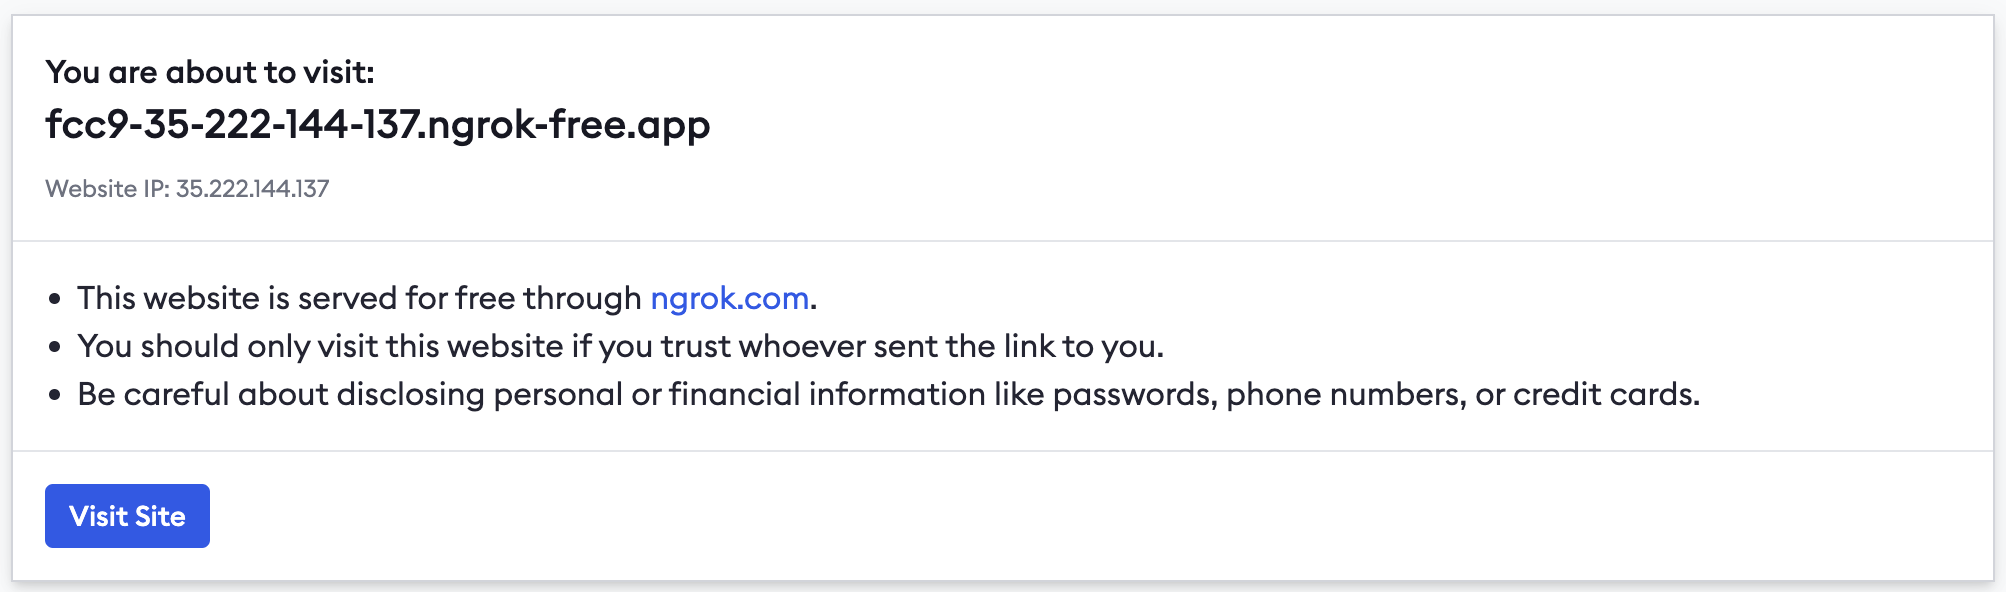

# Test HDFS

Upload the Hadoop distribution `.tar.gz` file (this is just a "big" file that's already there) to the HDFS filesystem using the command

    hdfs dfs -put <filename>

Check DFS usage before:

In [40]:
!hdfs dfsadmin -report | grep "^DFS Used" | tail -2

DFS Used: 24576 (24 KB)
DFS Used%: 0.00%


In [41]:
!echo $(basename $HADOOP_URL)
# create home directory on HDFS
!hdfs dfs -mkdir -p /user/root
# upload file to HDFS
!hdfs dfs -put $(basename $HADOOP_URL)
# list HDFS home
!hdfs dfs -ls -h

hadoop-3.3.6.tar.gz


04-Aug-24 09:39:50 PM - INFO: t=2024-08-04T21:39:50+0000 lvl=info msg="join connections" obj=join id=2665b7861377 l=127.0.0.1:9870 r=[2a02:8388:6cc5:e800:70ee:91e:4517:7eea]:51417
04-Aug-24 09:39:51 PM - INFO: t=2024-08-04T21:39:51+0000 lvl=info msg="join connections" obj=join id=e4735ac82a77 l=127.0.0.1:9870 r=[2a02:8388:6cc5:e800:70ee:91e:4517:7eea]:51417
04-Aug-24 09:39:51 PM - INFO: t=2024-08-04T21:39:51+0000 lvl=info msg="join connections" obj=join id=fcb5323a2c0e l=127.0.0.1:9870 r=[2a02:8388:6cc5:e800:70ee:91e:4517:7eea]:51417
04-Aug-24 09:39:51 PM - INFO: t=2024-08-04T21:39:51+0000 lvl=info msg="join connections" obj=join id=62a95c1da986 l=127.0.0.1:9870 r=[2a02:8388:6cc5:e800:70ee:91e:4517:7eea]:51417
04-Aug-24 09:39:51 PM - INFO: t=2024-08-04T21:39:51+0000 lvl=info msg="join connections" obj=join id=dcd5b9e3e9c1 l=127.0.0.1:9870 r=[2a02:8388:6cc5:e800:70ee:91e:4517:7eea]:51417
04-Aug-24 09:39:51 PM - INFO: t=2024-08-04T21:39:51+0000 lvl=info msg="join connections" obj=join id

Found 1 items
-rw-r--r--   1 root supergroup    696.3 M 2024-08-04 21:40 hadoop-3.3.6.tar.gz


You should now see that the value for DFS Used has increased from $0.0\%$ to a value $>0.0\%$.

In [43]:
!hdfs dfsadmin -report | grep "^DFS Used" | tail -2

DFS Used: 735870976 (701.78 MB)
DFS Used%: 0.64%


The same is shown in the Web UI (you might have to refresh the page).

| | |
| -: | -: |
| **Configured Capacity:**	| 107.72 GB |
| **Configured Remote Capacity:** | 	0 B |
| **DFS Used:** |	701.76 MB (0.64%) |




(see https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/SingleCluster.html#YARN_on_a_Single_Node)

Clean up.

In [44]:
!hdfs dfs -rm -r $(basename $HADOOP_URL)
!hdfs dfs -ls

Deleted hadoop-3.3.6.tar.gz


# Run a MapReduce job in local mode

If you run a MapReduce job at this point (without starting YARN), the job will run _in standalone mode_ (https://hadoop.apache.org/.../SingleCluster.html#Standalone_Operation). This means that the job will run as a single Java process and it is not going to make use of the pseudo-distributed cluster that we've just set up.

But first, let us reset the YARN and MapReduce configuration files to their initial empty state in case you are not running the notebook for the first time.

In [45]:
clear_conf_file(yarn_site_file)
clear_conf_file(mapred_site_file)

## How to find MapReduce examples

The Hadoop distribution comes with several examples (both sources and compiled). Here we are going to show how to find the runnable JAR files.

Search for MapReduce examples with `find`. The MapReduce examples JAR is named

```
hadoop-mapreduce-examples-${HADOOP_VERSION}.jar
```

In [46]:
!find $HADOOP_HOME -name "hadoop-mapreduce-examples-${HADOOP_VERSION}.jar"

/content/hadoop-3.3.6/share/hadoop/mapreduce/hadoop-mapreduce-examples-3.3.6.jar


Call the JAR file to get a list of all available MapReduce examples.

In [47]:
!hadoop jar $(find $HADOOP_HOME -name "hadoop-mapreduce-examples-${HADOOP_VERSION}.jar")

An example program must be given as the first argument.
Valid program names are:
  aggregatewordcount: An Aggregate based map/reduce program that counts the words in the input files.
  aggregatewordhist: An Aggregate based map/reduce program that computes the histogram of the words in the input files.
  bbp: A map/reduce program that uses Bailey-Borwein-Plouffe to compute exact digits of Pi.
  dbcount: An example job that count the pageview counts from a database.
  distbbp: A map/reduce program that uses a BBP-type formula to compute exact bits of Pi.
  grep: A map/reduce program that counts the matches of a regex in the input.
  join: A job that effects a join over sorted, equally partitioned datasets
  multifilewc: A job that counts words from several files.
  pentomino: A map/reduce tile laying program to find solutions to pentomino problems.
  pi: A map/reduce program that estimates Pi using a quasi-Monte Carlo method.
  randomtextwriter: A map/reduce program that writes 10GB of r

Run the `pi` example without arguments to get a usage message.

In [48]:
!hadoop jar $(find $HADOOP_HOME -name "hadoop-mapreduce-examples-${HADOOP_VERSION}.jar") pi

Usage: org.apache.hadoop.examples.QuasiMonteCarlo <nMaps> <nSamples>
Generic options supported are:
-conf <configuration file>        specify an application configuration file
-D <property=value>               define a value for a given property
-fs <file:///|hdfs://namenode:port> specify default filesystem URL to use, overrides 'fs.defaultFS' property from configurations.
-jt <local|resourcemanager:port>  specify a ResourceManager
-files <file1,...>                specify a comma-separated list of files to be copied to the map reduce cluster
-libjars <jar1,...>               specify a comma-separated list of jar files to be included in the classpath
-archives <archive1,...>          specify a comma-separated list of archives to be unarchived on the compute machines

The general command line syntax is:
command [genericOptions] [commandOptions]



## Run the `pi` MapReduce app

Run the `pi` example with


*   `<nMaps>` $=2$  
*   `<nSamples>` $= 100$



In [49]:
!yarn jar $(find $HADOOP_HOME -name "hadoop-mapreduce-examples-${HADOOP_VERSION}.jar") pi 2 100

Number of Maps  = 2
Samples per Map = 100
Wrote input for Map #0
Wrote input for Map #1
Starting Job
2024-08-04 21:40:53,638 INFO impl.MetricsConfig: Loaded properties from hadoop-metrics2.properties
2024-08-04 21:40:53,959 INFO impl.MetricsSystemImpl: Scheduled Metric snapshot period at 10 second(s).
2024-08-04 21:40:53,959 INFO impl.MetricsSystemImpl: JobTracker metrics system started
2024-08-04 21:40:54,521 INFO input.FileInputFormat: Total input files to process : 2
2024-08-04 21:40:54,547 INFO mapreduce.JobSubmitter: number of splits:2
2024-08-04 21:40:54,876 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_local737370061_0001
2024-08-04 21:40:54,876 INFO mapreduce.JobSubmitter: Executing with tokens: []
2024-08-04 21:40:55,164 INFO mapreduce.Job: The url to track the job: http://localhost:8080/
2024-08-04 21:40:55,165 INFO mapreduce.Job: Running job: job_local737370061_0001
2024-08-04 21:40:55,171 INFO mapred.LocalJobRunner: OutputCommitter set in config null
2024-08-0

# Start YARN

The script that we are going to use to start YARN is

    $HADOOP_HOME/sbin/start-yarn.sh

Before launching YARN, ensure proper configuration in both `yarn-site.xml` and `mapred-site.xml`. For YARN, it is essential to configure the `yarn.resourcemanager.hostname` as once this is set, many other services addresses depend on its value `${yarn.resourcemanager.hostname}` and do not need to be configured one by one.

In `mapred-site.xml` we want to configure MapReduce to submitting jobs to the YARN queue by default.

We just configured the minimal set of properties needed to run an example for this tutorial. In general, you might want to customize these XML configuration files to align with your system requirements and specifications.

Some useful links for configuring YARN:

*   https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/SingleCluster.html#YARN_on_a_Single_Node
* https://hadoop.apache.org/docs/stable/hadoop-yarn/hadoop-yarn-common/yarn-default.xml
*   https://hadoop.apache.org/docs/current/hadoop-yarn/hadoop-yarn-site/WebApplicationProxy.html



## Configure `yarn-site.xml`

In [50]:
clear_conf_file(yarn_site_file)
edit_conf_file(yarn_site_file, 'yarn.resourcemanager.hostname', 'localhost')
# Shuffle service that needs to be set for Map Reduce applications.
edit_conf_file(yarn_site_file, 'yarn.nodemanager.aux-services', 'mapreduce_shuffle')
# Configuration to enable or disable log aggregation (default is false)
edit_conf_file(yarn_site_file, 'yarn.log-aggregation-enable', 'true')
# Environment properties to be inherited by containers from NodeManagers
edit_conf_file(yarn_site_file, 'yarn.nodemanager.env-whitelist', 'JAVA_HOME,HADOOP_COMMON_HOME,HADOOP_HDFS_HOME,HADOOP_CONF_DIR,CLASSPATH_PREPEND_DISTCACHE,HADOOP_YARN_HOME,HADOOP_HOME,PATH,LANG,TZ,HADOOP_MAPRED_HOME')
# Web proxy address
edit_conf_file(yarn_site_file, 'yarn.web-proxy.address', '127.0.0.1:3141')
# NM Webapp address
#edit_conf_file(yarn_site_file, 'yarn.nodemanager.hostname', 'localhost:8042')
# Configurations for History Server
edit_conf_file(yarn_site_file, 'yarn.log-aggregation.retain-seconds', '600')
edit_conf_file(yarn_site_file, 'yarn.log-aggregation.retain-check-interval-seconds', '60')
print_conf_file(yarn_site_file)

04-Aug-24 09:41:03 PM - INFO: add property yarn.resourcemanager.hostname to /content/hadoop-3.3.6/etc/hadoop/yarn-site.xml
04-Aug-24 09:41:03 PM - INFO: add property yarn.nodemanager.aux-services to /content/hadoop-3.3.6/etc/hadoop/yarn-site.xml
04-Aug-24 09:41:03 PM - INFO: add property yarn.log-aggregation-enable to /content/hadoop-3.3.6/etc/hadoop/yarn-site.xml
04-Aug-24 09:41:03 PM - INFO: add property yarn.nodemanager.env-whitelist to /content/hadoop-3.3.6/etc/hadoop/yarn-site.xml
04-Aug-24 09:41:03 PM - INFO: add property yarn.web-proxy.address to /content/hadoop-3.3.6/etc/hadoop/yarn-site.xml
04-Aug-24 09:41:03 PM - INFO: add property yarn.log-aggregation.retain-seconds to /content/hadoop-3.3.6/etc/hadoop/yarn-site.xml
04-Aug-24 09:41:03 PM - INFO: add property yarn.log-aggregation.retain-check-interval-seconds to /content/hadoop-3.3.6/etc/hadoop/yarn-site.xml


<?xml version="1.0" ?>
<configuration>
	




	<property>
		<name>yarn.resourcemanager.hostname</name>
		<value>localhost</value>
	</property>
	<property>
		<name>yarn.nodemanager.aux-services</name>
		<value>mapreduce_shuffle</value>
	</property>
	<property>
		<name>yarn.log-aggregation-enable</name>
		<value>true</value>
	</property>
	<property>
		<name>yarn.nodemanager.env-whitelist</name>
		<value>JAVA_HOME,HADOOP_COMMON_HOME,HADOOP_HDFS_HOME,HADOOP_CONF_DIR,CLASSPATH_PREPEND_DISTCACHE,HADOOP_YARN_HOME,HADOOP_HOME,PATH,LANG,TZ,HADOOP_MAPRED_HOME</value>
	</property>
	<property>
		<name>yarn.web-proxy.address</name>
		<value>127.0.0.1:3141</value>
	</property>
	<property>
		<name>yarn.log-aggregation.retain-seconds</name>
		<value>600</value>
	</property>
	<property>
		<name>yarn.log-aggregation.retain-check-interval-seconds</name>
		<value>60</value>
	</property>
</configuration>



### Some explanations

**`yarn.web-proxy.address`** is needed so that `start-yarn.sh` also launches the Web proxy (needed for navigating the different Web services). Here is the relevant code from `start-yarn.sh`:

```
# start proxyserver
PROXYSERVER=$("${HADOOP_HDFS_HOME}/bin/hdfs" getconf -confKey  yarn.web-proxy.address 2>&- | cut -f1 -d:)
if [[ -n ${PROXYSERVER} ]]; then
 hadoop_uservar_su yarn proxyserver "${HADOOP_YARN_HOME}/bin/yarn" \
      --config "${HADOOP_CONF_DIR}" \
      --workers \
      --hostnames "${PROXYSERVER}" \
      --daemon start \
      proxyserver
 (( HADOOP_JUMBO_RETCOUNTER=HADOOP_JUMBO_RETCOUNTER + $? ))
fi
```
We just picked an arbitrary port `3141`.

To check if `yarn.web-proxy.address` use:

    hdfs getconf -confKey  yarn.web-proxy.address

In [51]:
!hdfs getconf -confKey  yarn.web-proxy.address

127.0.0.1:3141


**`yarn.log-aggregation-enable`** needs to be set to `true` (by default it is `false`) in order to be able to view the logs of the application after it's completed using the command

    yarn logs -applicationId <app ID>
    
When log aggregation is enabled, log files are collated from local containers to a central location (see [Running on YARN/Debugging your application](https://spark.apache.org/docs/3.5.0/running-on-yarn.html#debugging-your-application)).

**`yarn.log-aggregation.retain-seconds`** determines how long to keep aggregation logs before deleting them. I configured 10 minutes for this tutorial.

**`yarn.log-aggregation.retain-check-interval-seconds`** from [yarn-default.xml](https://hadoop.apache.org/docs/stable/hadoop-yarn/hadoop-yarn-common/yarn-default.xml) How long to wait between aggregated log retention checks. If set to 0 or a negative value then the value is computed as one-tenth of the aggregated log retention time. Be careful set this too small and you will spam the name node.

## Configure `mapred-site.xml`

We want to run MapReduce jobs on YARN by default (property `mapreduce.framework.name`) and we want to configure the address for the JobHistory daemon.

In [52]:
clear_conf_file(mapred_site_file)
edit_conf_file(mapred_site_file, 'mapreduce.framework.name', 'yarn')
# Shuffle service that needs to be set for Map Reduce applications.
edit_conf_file(mapred_site_file, 'mapreduce.application.classpath',
               os.environ['HADOOP_HOME'] + '/share/hadoop/mapreduce/*:' +
               os.environ['HADOOP_HOME']+ '/share/hadoop/mapreduce/lib/*')
# this should also work (with the variable ${HADOOP_HOME})
# edit_conf_file(mapred_site_file, 'mapreduce.application.classpath',
#               '${HADOOP_HOME}/share/hadoop/mapreduce/*:' +
#               '${HADOOP_HOME}/share/hadoop/mapreduce/lib/*')
# Configurations for History Server
edit_conf_file(mapred_site_file, 'mapreduce.jobhistory.address', 'localhost:10020')
edit_conf_file(mapred_site_file, 'mapreduce.jobhistory.webapp.address', 'localhost:19888')
print_conf_file(mapred_site_file)

04-Aug-24 09:41:06 PM - INFO: add property mapreduce.framework.name to /content/hadoop-3.3.6/etc/hadoop/mapred-site.xml
04-Aug-24 09:41:06 PM - INFO: add property mapreduce.application.classpath to /content/hadoop-3.3.6/etc/hadoop/mapred-site.xml
04-Aug-24 09:41:06 PM - INFO: add property mapreduce.jobhistory.address to /content/hadoop-3.3.6/etc/hadoop/mapred-site.xml
04-Aug-24 09:41:06 PM - INFO: add property mapreduce.jobhistory.webapp.address to /content/hadoop-3.3.6/etc/hadoop/mapred-site.xml


<?xml version="1.0" ?>
<configuration>
	


	<property>
		<name>mapreduce.framework.name</name>
		<value>yarn</value>
	</property>
	<property>
		<name>mapreduce.application.classpath</name>
		<value>/content/hadoop-3.3.6/share/hadoop/mapreduce/*:/content/hadoop-3.3.6/share/hadoop/mapreduce/lib/*</value>
	</property>
	<property>
		<name>mapreduce.jobhistory.address</name>
		<value>localhost:10020</value>
	</property>
	<property>
		<name>mapreduce.jobhistory.webapp.address</name>
		<value>localhost:19888</value>
	</property>
</configuration>



## Launch YARN

In [53]:
!$HADOOP_HOME/sbin/stop-yarn.sh
!$HADOOP_HOME/sbin/start-yarn.sh

Stopping nodemanagers
Stopping resourcemanager
Stopping proxy server [127.0.0.1]
127.0.0.1: Warning: Permanently added '127.0.0.1' (ED25519) to the list of known hosts.
Starting resourcemanager
Starting nodemanagers


In [54]:
!lsof -n -i -P +c0 -sTCP:LISTEN -ac java

COMMAND  PID USER   FD   TYPE DEVICE SIZE/OFF NODE NAME
java    2085 root  341u  IPv4  65913      0t0  TCP *:9870 (LISTEN)
java    2085 root  349u  IPv4  67634      0t0  TCP 127.0.0.1:9000 (LISTEN)
java    2190 root  342u  IPv4  66815      0t0  TCP *:9866 (LISTEN)
java    2190 root  345u  IPv4  67292      0t0  TCP 127.0.0.1:35485 (LISTEN)
java    2190 root  374u  IPv4  68044      0t0  TCP *:9864 (LISTEN)
java    2190 root  375u  IPv4  67490      0t0  TCP *:9867 (LISTEN)
java    2417 root  343u  IPv4  69545      0t0  TCP *:9868 (LISTEN)
java    6522 root  366u  IPv4 170487      0t0  TCP 127.0.0.1:8088 (LISTEN)
java    6630 root  382u  IPv4 170725      0t0  TCP *:43465 (LISTEN)
java    6630 root  393u  IPv4 170752      0t0  TCP *:8040 (LISTEN)
java    6630 root  403u  IPv4 170762      0t0  TCP *:13562 (LISTEN)


We now have some new `java` processes that have been added to the list of listening ports (you might need to wait and refresh the previous cell to see them all):
```
COMMAND   PID USER   FD   TYPE DEVICE SIZE/OFF NODE NAME
java    13177 root  341u  IPv4 357089      0t0  TCP *:9870 (LISTEN)
java    13177 root  349u  IPv4 358597      0t0  TCP 127.0.0.1:9000 (LISTEN)
java    13297 root  342u  IPv4 359615      0t0  TCP *:9866 (LISTEN)
java    13297 root  345u  IPv4 358674      0t0  TCP 127.0.0.1:40349 (LISTEN)
java    13297 root  374u  IPv4 358786      0t0  TCP *:9864 (LISTEN)
java    13297 root  375u  IPv4 358790      0t0  TCP *:9867 (LISTEN)
java    13515 root  343u  IPv4 360840      0t0  TCP *:9868 (LISTEN)
java    27447 root  366u  IPv4 756489      0t0  TCP 127.0.0.1:8088 (LISTEN)
java    27447 root  373u  IPv4 759769      0t0  TCP 127.0.0.1:8033 (LISTEN)
java    27447 root  383u  IPv4 758559      0t0  TCP 127.0.0.1:8031 (LISTEN)
java    27447 root  393u  IPv4 759823      0t0  TCP 127.0.0.1:8030 (LISTEN)
java    27447 root  403u  IPv4 759857      0t0  TCP 127.0.0.1:8032 (LISTEN)
java    27735 root  340u  IPv4 759788      0t0  TCP 127.0.0.1:3141 (LISTEN)
```

YARN ports:

port number | description | configured in
--- | --- | --- |
8088 | yarn.resourcemanager.webapp.address | [yarn-default.xml](https://hadoop.apache.org/docs/r3.0.0/hadoop-yarn/hadoop-yarn-common/yarn-default.xml) |
8030 | yarn.resourcemanager.scheduler.address | [yarn-default.xml](https://hadoop.apache.org/docs/r3.0.0/hadoop-yarn/hadoop-yarn-common/yarn-default.xml) |
8031 | yarn.resourcemanager.resource-tracker.address | [yarn-default.xml](https://hadoop.apache.org/docs/r3.0.0/hadoop-yarn/hadoop-yarn-common/yarn-default.xml) |
8032 | yarn.resourcemanager.address | [yarn-default.xml](https://hadoop.apache.org/docs/r3.0.0/hadoop-yarn/hadoop-yarn-common/yarn-default.xml) |
8033 | yarn.resourcemanager.admin.address | [yarn-default.xml](https://hadoop.apache.org/docs/r3.0.0/hadoop-yarn/hadoop-yarn-common/yarn-default.xml) |
8040 | yarn.nodemanager.localizer.address | [yarn-default.xml](https://hadoop.apache.org/docs/r3.0.0/hadoop-yarn/hadoop-yarn-common/yarn-default.xml) |
8042 | yarn.nodemanager.webapp.address | [yarn-default.xml](https://hadoop.apache.org/docs/r3.0.0/hadoop-yarn/hadoop-yarn-common/yarn-default.xml) |

Web Proxy port:

port number | description | configured in
--- | --- | --- |
3141 | yarn.web-proxy.address | yarn-site.xml



## Verify that all YARN services are up and running

In [55]:
%%bash
counter=0
until [ $counter -gt 20 ]
do
  ((counter++))
  sleep 1
  # counting lines + header
  if [ $(lsof -n -aiTCP:8088 -aiTCP:8030 -aiTCP:8031 -aiTCP:8032 -aiTCP:8033 -aiTCP:8042 -aiTCP:3141 -P +c0 -sTCP:LISTEN -ac java |wc -l ) -eq 8 ]
  then
   echo "YARN is up and running"
   echo "Time to start: $counter secs"
   exit
  fi
done
echo "Some YARN ports are missing. Wait some more or restart YARN."

YARN is up and running
Time to start: 3 secs


If YARN is running correctly, you should see one node listed when calling `yarn node -list`

In [56]:
!yarn node -list

2024-08-04 21:41:44,453 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at localhost/127.0.0.1:8032
Total Nodes:1
         Node-Id	     Node-State	Node-Http-Address	Number-of-Running-Containers
ced9dfeb9431:43465	        RUNNING	ced9dfeb9431:8042	                           0


## Serve the YARN Web UI


In [57]:
!wget localhost:8088

--2024-08-04 21:41:47--  http://localhost:8088/
Resolving localhost (localhost)... 127.0.0.1, ::1
Connecting to localhost (localhost)|127.0.0.1|:8088... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://localhost:8088/cluster [following]
--2024-08-04 21:41:47--  http://localhost:8088/cluster
Reusing existing connection to localhost:8088.
HTTP request sent, awaiting response... 200 OK
Length: 13683 (13K) [text/html]
Saving to: ‘index.html.1’

index.html.1        100%[===================>]  13.36K  --.-KB/s    in 0s      

2024-08-04 21:41:47 (113 MB/s) - ‘index.html.1’ saved [13683/13683]



In [58]:
%%capture yarn_url
if IN_COLAB:
  port = 8088
  output.serve_kernel_port_as_window(port, path='/cluster')

In [59]:
if IN_COLAB:
  yarn_url.show()

<IPython.core.display.Javascript object>

### With ngrok

In [90]:
if NGROK:
  # Open a ngrok tunnel to the HTTP server
  public_url_yarn = ngrok.connect(port).public_url
  print(f'Click on {public_url_yarn} to open the YARN Web UI')

04-Aug-24 10:03:44 PM - INFO: Opening tunnel named: http-19888-bc28f8ac-3a86-4455-93a1-793c9d5229b1
04-Aug-24 10:03:44 PM - INFO: t=2024-08-04T22:03:44+0000 lvl=info msg=start pg=/api/tunnels id=266b646fe2c1b717
04-Aug-24 10:03:44 PM - INFO: t=2024-08-04T22:03:44+0000 lvl=info msg="started tunnel" obj=tunnels name=http-19888-bc28f8ac-3a86-4455-93a1-793c9d5229b1 addr=http://localhost:19888 url=https://12b6-34-125-221-95.ngrok-free.app


Click on https://12b6-34-125-221-95.ngrok-free.app to open the YARN Web UI


04-Aug-24 10:03:44 PM - INFO: t=2024-08-04T22:03:44+0000 lvl=info msg=end pg=/api/tunnels id=266b646fe2c1b717 status=201 dur=84.271489ms


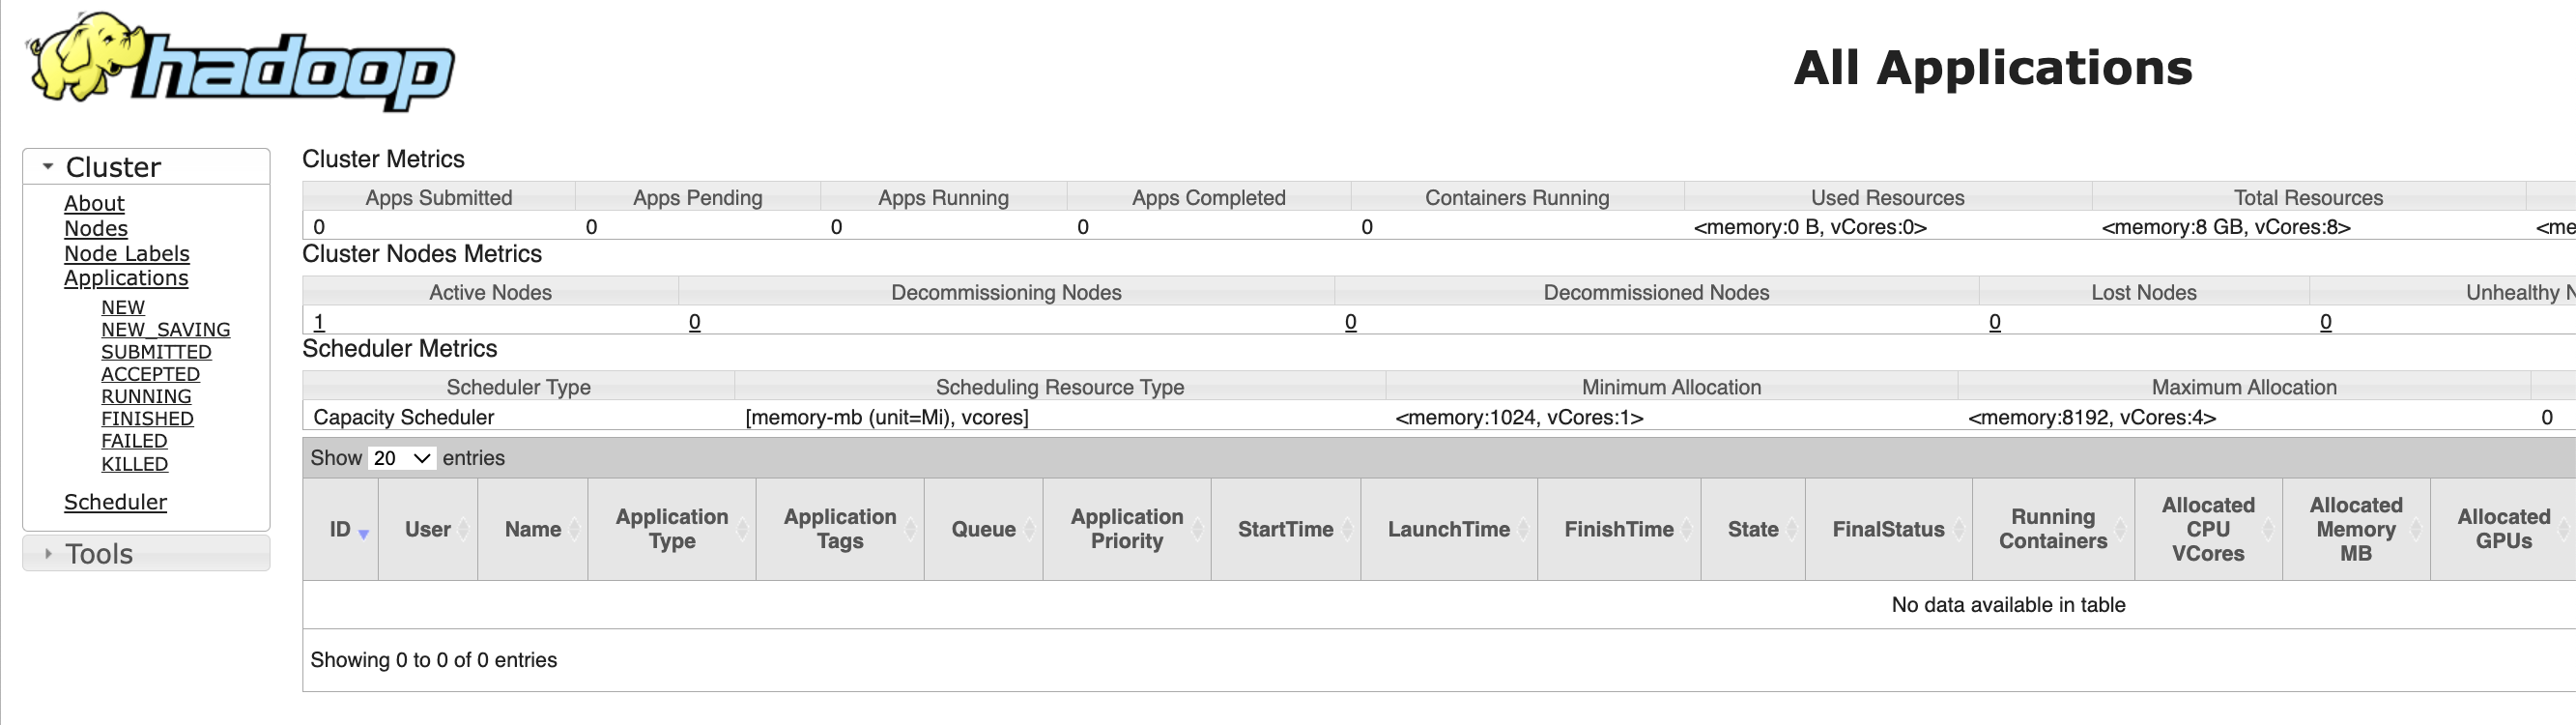
YARN Web UI: empty queue

No application is shown yet in the YARN UI since we have only ran a job locally.

Next, we want to start the History Server in order to be able to view jobs logfile when they're finished.

# Start Job History Server

As already seen, HDFS daemons are:

*   NameNode
*   SecondaryNameNode
*   DataNode

YARN daemons are:

*   ResourceManager
*   NodeManager
*   WebAppProxy.

*If MapReduce is to be used, then the MapReduce Job History Server will also be running. For large installations, these are generally running on separate hosts.*

From: [https://hadoop.apache.org/docs/stable/hadoop-project-dist/hadoop-common/ClusterSetup.html](https://hadoop.apache.org/docs/stable/hadoop-project-dist/hadoop-common/ClusterSetup.html).

In [61]:
!mapred --daemon stop historyserver
!mapred --daemon start historyserver

## Start the Job History Server Web UI

In [62]:
!wget localhost:19888

--2024-08-04 21:44:15--  http://localhost:19888/
Resolving localhost (localhost)... 127.0.0.1, ::1
Connecting to localhost (localhost)|127.0.0.1|:19888... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://localhost:19888/jobhistory [following]
--2024-08-04 21:44:16--  http://localhost:19888/jobhistory
Reusing existing connection to localhost:19888.
HTTP request sent, awaiting response... 200 OK
Length: 7791 (7.6K) [text/html]
Saving to: ‘index.html.2’

index.html.2        100%[===================>]   7.61K  --.-KB/s    in 0s      

2024-08-04 21:44:16 (374 MB/s) - ‘index.html.2’ saved [7791/7791]



In [63]:
if IN_COLAB:
  port = 19888
  output.serve_kernel_port_as_window(port, path='/jobhistory')

<IPython.core.display.Javascript object>

### With ngrok

In [91]:
if NGROK:
  # Open a ngrok tunnel to the HTTP server
  public_url_jh = ngrok.connect(19888).public_url
  print(f'Click on {public_url_jh} to open the History Server Web UI')

04-Aug-24 10:04:16 PM - INFO: Opening tunnel named: http-19888-8c21b0d4-3c5d-4210-bab1-47759f25fe5a
04-Aug-24 10:04:16 PM - INFO: t=2024-08-04T22:04:16+0000 lvl=info msg=start pg=/api/tunnels id=191c3defe7a4c996
04-Aug-24 10:04:17 PM - INFO: t=2024-08-04T22:04:17+0000 lvl=info msg="started tunnel" obj=tunnels name=http-19888-8c21b0d4-3c5d-4210-bab1-47759f25fe5a addr=http://localhost:19888 url=https://89a5-34-125-221-95.ngrok-free.app


Click on https://89a5-34-125-221-95.ngrok-free.app to open the History Server Web UI


04-Aug-24 10:04:17 PM - INFO: t=2024-08-04T22:04:17+0000 lvl=info msg=end pg=/api/tunnels id=191c3defe7a4c996 status=201 dur=63.706578ms


# Submit the MapReduce `pi` example to YARN

After submitting the job, you should now see the `pi` application listed in the YARN UI (you might need to refresh the Web page).

In [65]:
!yarn jar $(find $HADOOP_HOME -name "hadoop-mapreduce-examples-${HADOOP_VERSION}.jar") pi 2 100

Number of Maps  = 2
Samples per Map = 100
Wrote input for Map #0
Wrote input for Map #1
Starting Job
2024-08-04 21:46:58,124 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at localhost/127.0.0.1:8032
2024-08-04 21:46:59,049 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1722807696501_0001
2024-08-04 21:46:59,536 INFO input.FileInputFormat: Total input files to process : 2
2024-08-04 21:47:00,122 INFO mapreduce.JobSubmitter: number of splits:2
2024-08-04 21:47:00,900 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1722807696501_0001
2024-08-04 21:47:00,900 INFO mapreduce.JobSubmitter: Executing with tokens: []


04-Aug-24 09:47:01 PM - INFO: t=2024-08-04T21:47:01+0000 lvl=info msg="join connections" obj=join id=6bb8812e3db5 l=127.0.0.1:8088 r=[2a02:8388:6cc5:e800:70ee:91e:4517:7eea]:51420


2024-08-04 21:47:01,380 INFO conf.Configuration: resource-types.xml not found
2024-08-04 21:47:01,381 INFO resource.ResourceUtils: Unable to find 'resource-types.xml'.
2024-08-04 21:47:01,895 INFO impl.YarnClientImpl: Submitted application application_1722807696501_0001
2024-08-04 21:47:02,104 INFO mapreduce.Job: The url to track the job: http://127.0.0.1:3141/proxy/application_1722807696501_0001/
2024-08-04 21:47:02,106 INFO mapreduce.Job: Running job: job_1722807696501_0001


04-Aug-24 09:47:07 PM - INFO: t=2024-08-04T21:47:07+0000 lvl=info msg="join connections" obj=join id=6483558ede3e l=127.0.0.1:8088 r=[2a02:8388:6cc5:e800:70ee:91e:4517:7eea]:51420


2024-08-04 21:47:18,469 INFO mapreduce.Job: Job job_1722807696501_0001 running in uber mode : false
2024-08-04 21:47:18,471 INFO mapreduce.Job:  map 0% reduce 0%
2024-08-04 21:47:32,821 INFO mapreduce.Job:  map 100% reduce 0%
2024-08-04 21:47:39,905 INFO mapreduce.Job:  map 100% reduce 100%
2024-08-04 21:47:40,923 INFO mapreduce.Job: Job job_1722807696501_0001 completed successfully
2024-08-04 21:47:41,081 INFO mapreduce.Job: Counters: 54
	File System Counters
		FILE: Number of bytes read=50
		FILE: Number of bytes written=829623
		FILE: Number of read operations=0
		FILE: Number of large read operations=0
		FILE: Number of write operations=0
		HDFS: Number of bytes read=528
		HDFS: Number of bytes written=215
		HDFS: Number of read operations=13
		HDFS: Number of large read operations=0
		HDFS: Number of write operations=3
		HDFS: Number of bytes read erasure-coded=0
	Job Counters 
		Launched map tasks=2
		Launched reduce tasks=1
		Data-local map tasks=2
		Total time spent by all maps

By refreshing the Web page, you should see the application change state from "ACCEPTED" to "RUNNING" and, finally, "FINISHED".

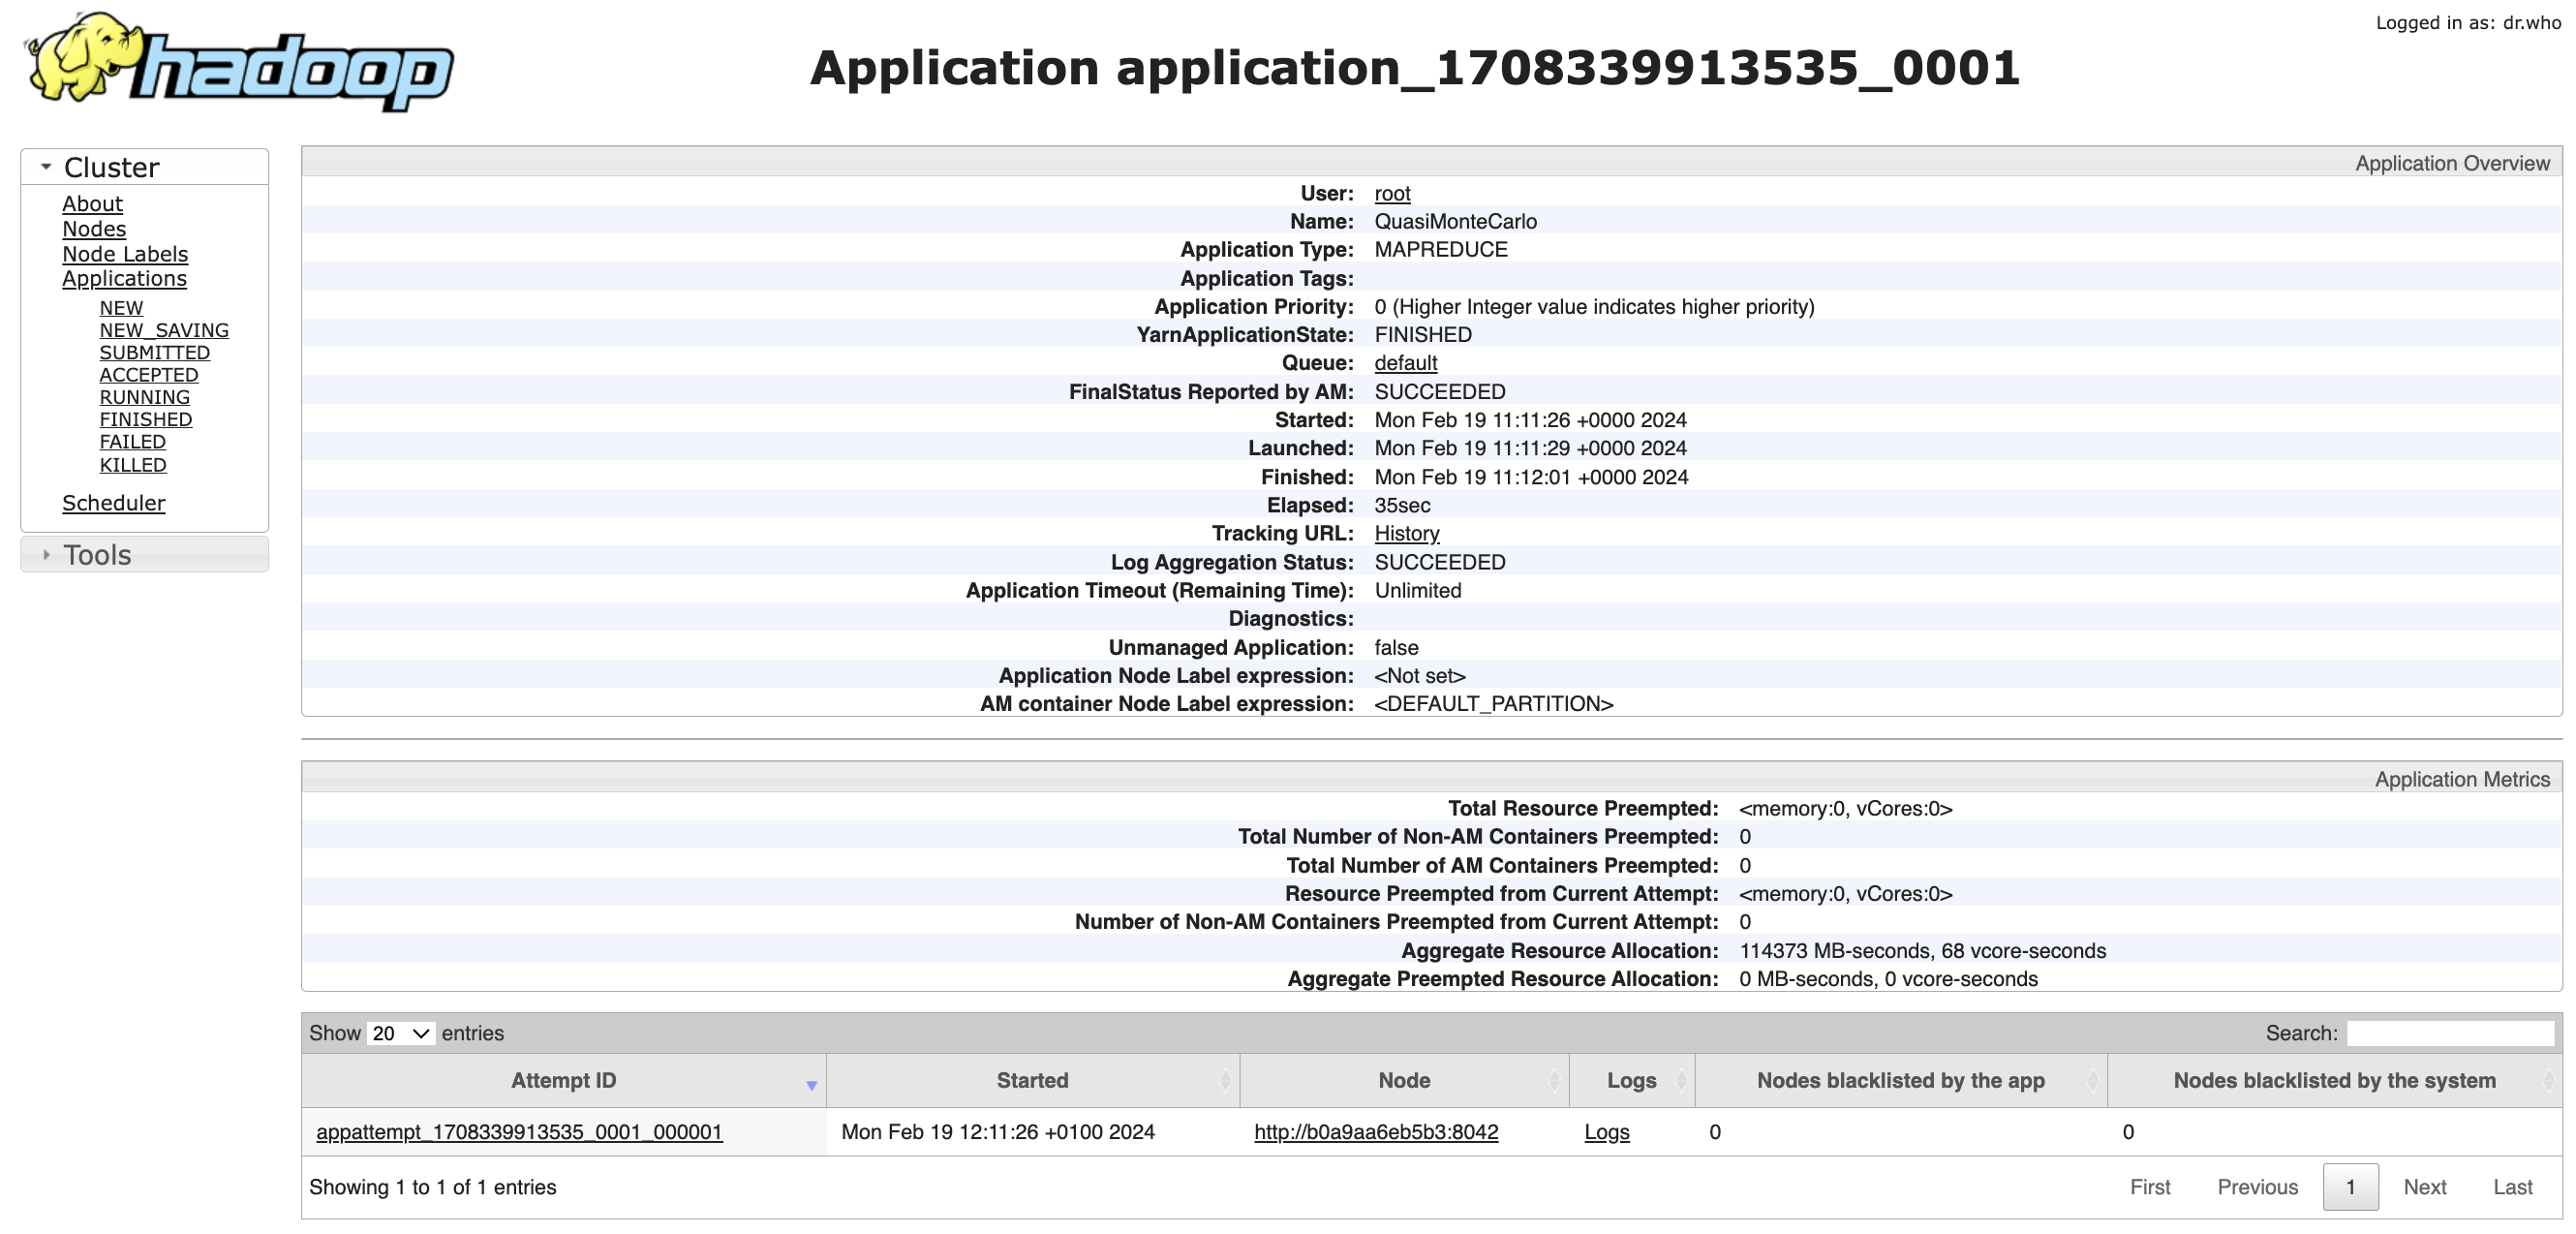
YARN Web UI: application running

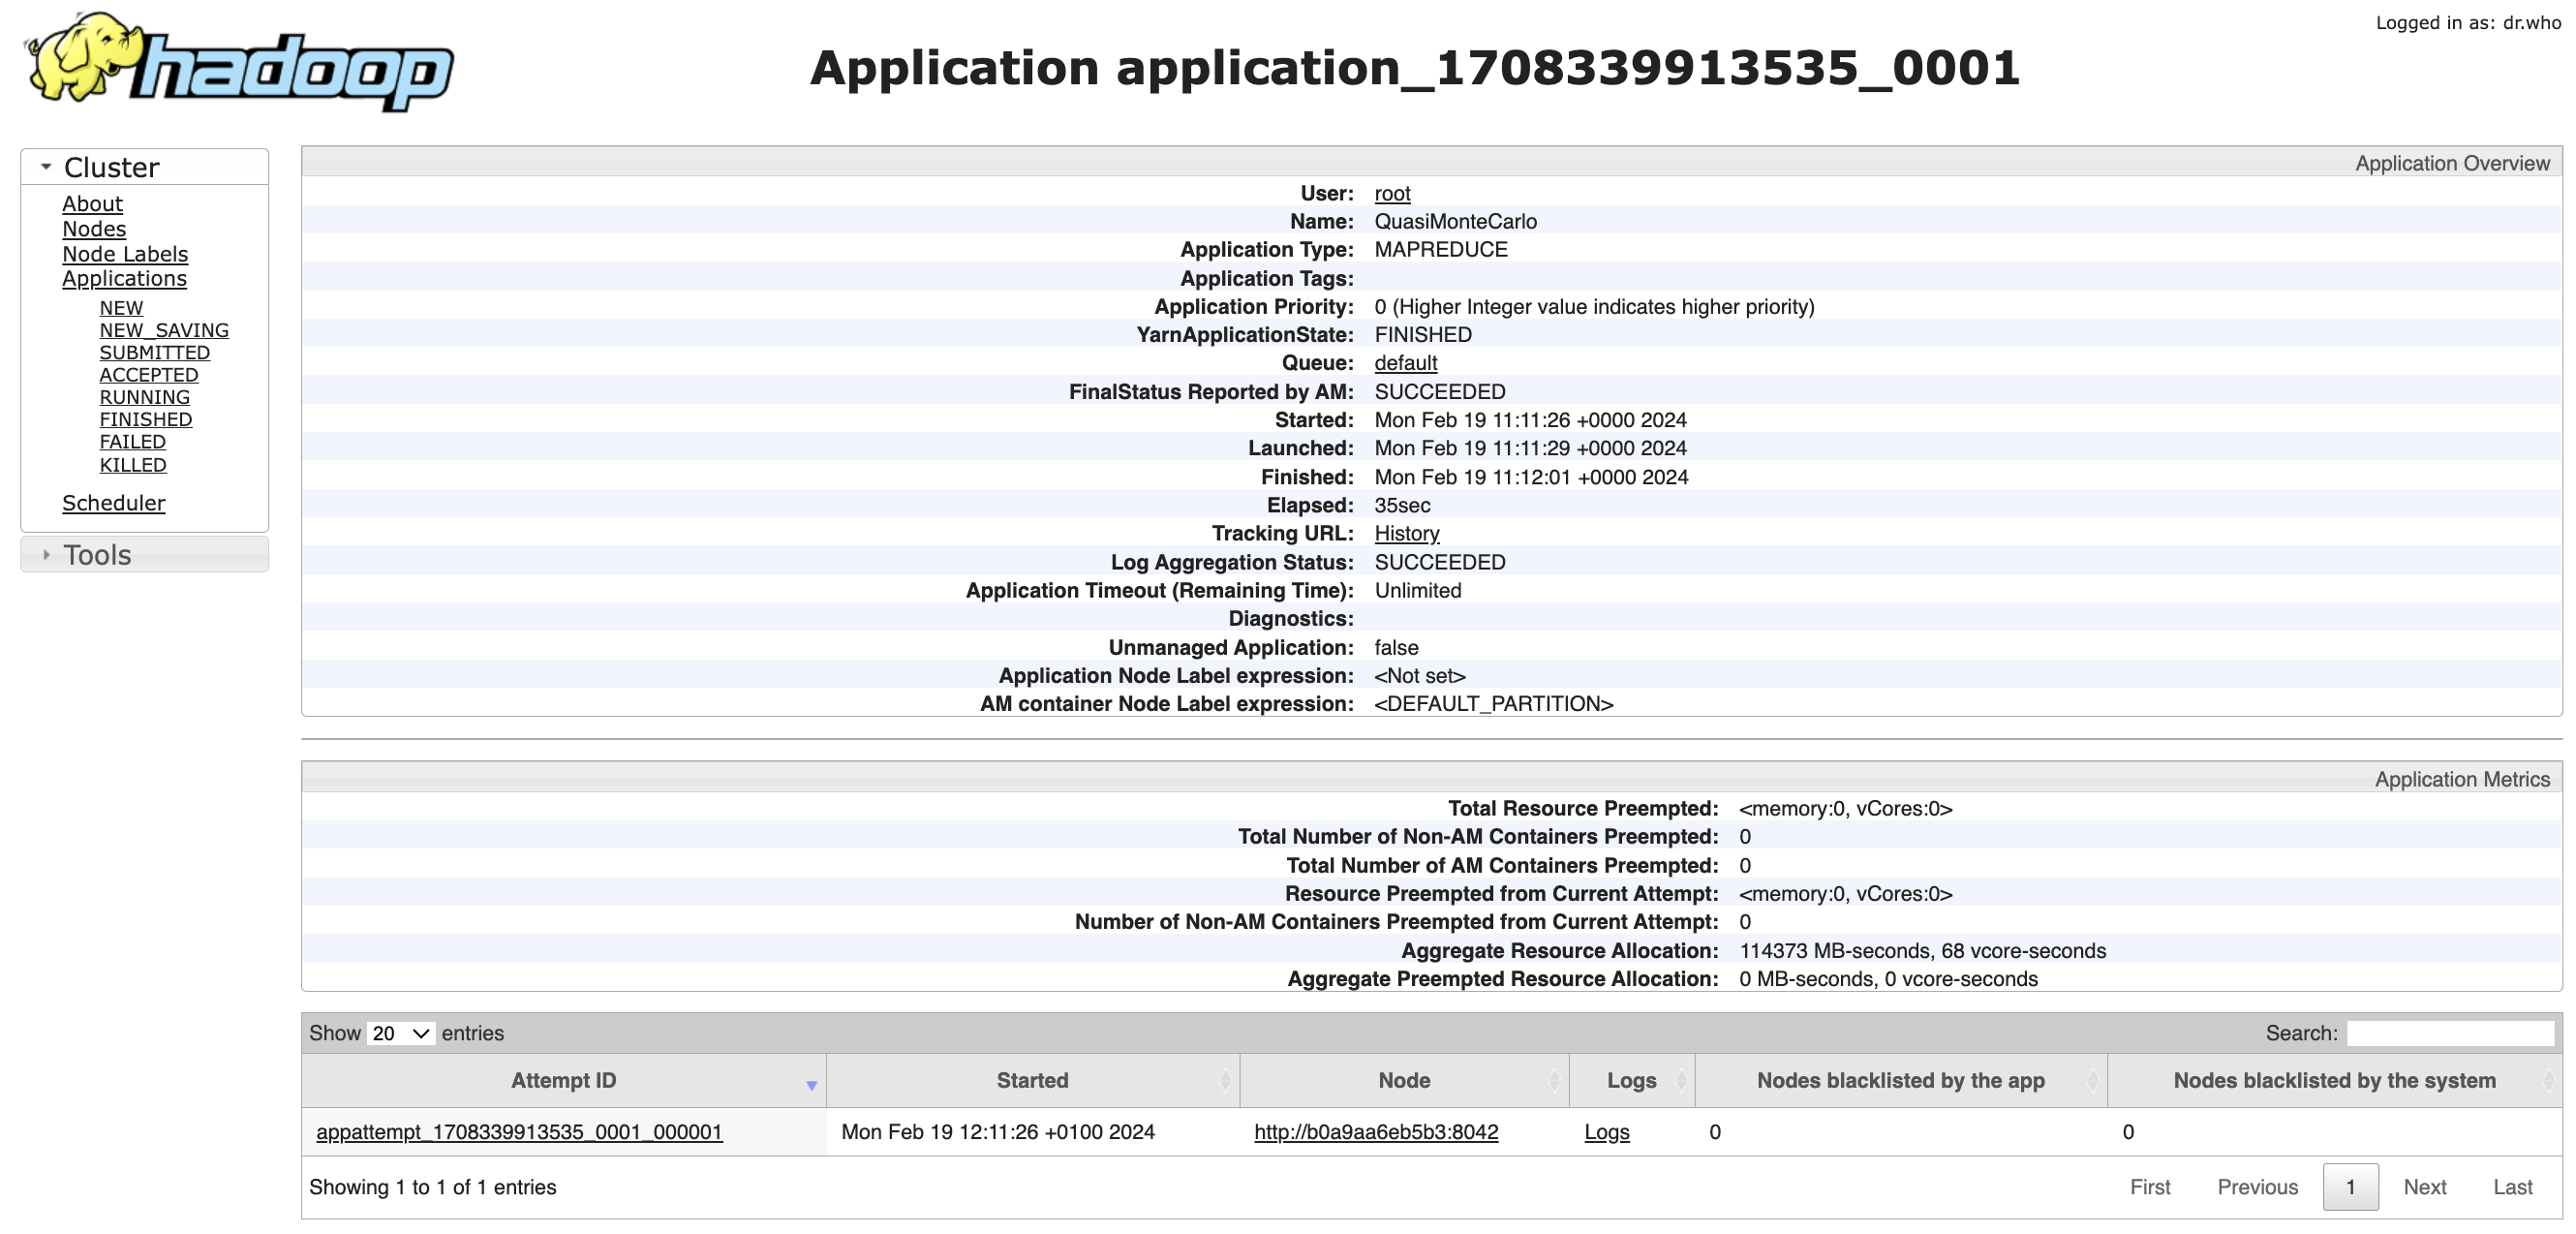
YARN Web UI: application completed

After completion, the application will be listed in the Job History Server UI.

## View your application's logs

There are multiple ways to view an application's log files.


1.   on the command-line with `yarn logs -applicationId <appID>`
2.   in the History Server Web UI by clicking on `logs` (after app completion)



In [66]:
%%bash
appID=$(yarn application -list -appStates ALL 2>/dev/null|tail -1|grep -E -o "application_[0-9]+_[0-9]+")
echo Application ID = $appID
yarn logs -applicationId $appID

Application ID = application_1722807696501_0001
Container: container_1722807696501_0001_01_000002 on ced9dfeb9431_43465
LogAggregationType: AGGREGATED
LogType:directory.info
LogLastModifiedTime:Sun Aug 04 21:47:47 +0000 2024
LogLength:1953
LogContents:
ls -l:
total 32
-rw-r--r-- 1 root root  129 Aug  4 21:47 container_tokens
-rwx------ 1 root root  668 Aug  4 21:47 default_container_executor_session.sh
-rwx------ 1 root root  723 Aug  4 21:47 default_container_executor.sh
lrwxrwxrwx 1 root root  105 Aug  4 21:47 job.jar -> /tmp/hadoop-root/nm-local-dir/usercache/root/appcache/application_1722807696501_0001/filecache/11/job.jar
lrwxrwxrwx 1 root root  105 Aug  4 21:47 job.xml -> /tmp/hadoop-root/nm-local-dir/usercache/root/appcache/application_1722807696501_0001/filecache/13/job.xml
-rwx------ 1 root root 5300 Aug  4 21:47 launch_container.sh
drwx--x--- 2 root root 4096 Aug  4 21:47 tmp
find -L . -maxdepth 5 -ls:
  5139104      4 drwx--x---   3 root     root         4096 Aug  4 21:47 .


In [67]:
!mapred job -list all

2024-08-04 21:49:23,502 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at localhost/127.0.0.1:8032


2024-08-04 21:49:27,853 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at localhost/127.0.0.1:8032
2024-08-04 21:49:29,538 INFO conf.Configuration: resource-types.xml not found
2024-08-04 21:49:29,538 INFO resource.ResourceUtils: Unable to find 'resource-types.xml'.
Total jobs:1
                  JobId	             JobName	     State	     StartTime	    UserName	       Queue	  Priority	 UsedContainers	 RsvdContainers	 UsedMem	 RsvdMem	 NeededMem	   AM info
 job_1722807696501_0001	     QuasiMonteCarlo	 SUCCEEDED	 1722808021651	        root	     default	   DEFAULT	            N/A	            N/A	     N/A	     N/A	       N/A	http://127.0.0.1:3141/proxy/application_1722807696501_0001/


# View Hadoop logfiles

By default, Hadoop writes logs to `$HADOOP_HOME/logs`.

In [68]:
!ls -halt $HADOOP_HOME/logs

total 432K
-rw-r--r--  1 root root  74K Aug  4 21:49 hadoop-root-datanode-ced9dfeb9431.log
-rw-r--r--  1 root root  39K Aug  4 21:49 hadoop-root-historyserver-ced9dfeb9431.log
drwxr-xr-x  2 root root 4.0K Aug  4 21:47 userlogs
-rw-r--r--  1 root root  76K Aug  4 21:47 hadoop-root-nodemanager-ced9dfeb9431.log
-rw-r--r--  1 root root  57K Aug  4 21:47 hadoop-root-namenode-ced9dfeb9431.log
-rw-r--r--  1 root root  67K Aug  4 21:47 hadoop-root-resourcemanager-ced9dfeb9431.log
-rw-r--r--  1 root root 2.9K Aug  4 21:44 hadoop-root-historyserver-ced9dfeb9431.out
drwxr-xr-x  3 root root 4.0K Aug  4 21:44 .
-rw-r--r--  1 root root 2.9K Aug  4 21:41 hadoop-root-nodemanager-ced9dfeb9431.out
-rw-r--r--  1 root root  29K Aug  4 21:41 hadoop-root-proxyserver-ced9dfeb9431.log
-rw-r--r--  1 root root 3.0K Aug  4 21:41 hadoop-root-resourcemanager-ced9dfeb9431.out
-rw-r--r--  1 root root  828 Aug  4 21:41 hadoop-root-proxyserver-ced9dfeb9431.out
-rw-r--r--  1 root root  36K Aug  4 21:29 hadoop-root-seco

This is for instance the NameNode's log.

In [69]:
!tail $HADOOP_HOME/logs/hadoop-root-namenode-*.log

2024-08-04 21:47:38,778 INFO org.apache.hadoop.hdfs.StateChange: DIR* completeFile: /tmp/hadoop-yarn/staging/root/.staging/job_1722807696501_0001/job_1722807696501_0001_1.jhist is closed by DFSClient_NONMAPREDUCE_-1599044529_1
2024-08-04 21:47:38,792 INFO org.apache.hadoop.hdfs.StateChange: BLOCK* allocate blk_1073741845_1021, replicas=127.0.0.1:9866 for /tmp/hadoop-yarn/staging/history/done_intermediate/root/job_1722807696501_0001.summary_tmp
2024-08-04 21:47:38,811 INFO org.apache.hadoop.hdfs.StateChange: DIR* completeFile: /tmp/hadoop-yarn/staging/history/done_intermediate/root/job_1722807696501_0001.summary_tmp is closed by DFSClient_NONMAPREDUCE_-1599044529_1
2024-08-04 21:47:38,859 INFO org.apache.hadoop.hdfs.StateChange: BLOCK* allocate blk_1073741846_1022, replicas=127.0.0.1:9866 for /tmp/hadoop-yarn/staging/history/done_intermediate/root/job_1722807696501_0001-1722808021504-root-QuasiMonteCarlo-1722808058302-2-1-SUCCEEDED-default-1722808036732.jhist_tmp
2024-08-04 21:47:38,877

Show most recent error or warning messages

In [70]:
!grep "ERROR\|WARN" $HADOOP_HOME/logs/*.log | sort -r -k2 | head

/content/hadoop-3.3.6/logs/hadoop-root-datanode-ced9dfeb9431.log:2024-08-04 21:49:25,396 WARN org.apache.hadoop.hdfs.DFSUtil: Unexpected value for data transfer bytes=154 duration=0
/content/hadoop-3.3.6/logs/hadoop-root-datanode-ced9dfeb9431.log:2024-08-04 21:49:25,250 WARN org.apache.hadoop.hdfs.DFSUtil: Unexpected value for data transfer bytes=670 duration=0
/content/hadoop-3.3.6/logs/hadoop-root-datanode-ced9dfeb9431.log:2024-08-04 21:49:25,216 WARN org.apache.hadoop.hdfs.DFSUtil: Unexpected value for data transfer bytes=154 duration=0
/content/hadoop-3.3.6/logs/hadoop-root-nodemanager-ced9dfeb9431.log:2024-08-04 21:47:45,924 WARN org.apache.hadoop.yarn.server.nodemanager.DefaultContainerExecutor: delete returned false for path: [/tmp/hadoop-root/nm-local-dir/usercache/root/appcache/application_1722807696501_0001/container_1722807696501_0001_01_000001/sysfs]
/content/hadoop-3.3.6/logs/hadoop-root-nodemanager-ced9dfeb9431.log:2024-08-04 21:47:45,924 WARN org.apache.hadoop.yarn.serve

Show most recent error messages in Hadoop logfiles.

In [71]:
!grep "ERROR" $HADOOP_HOME/logs/*.log | sort -r -k2 | head

/content/hadoop-3.3.6/logs/hadoop-root-historyserver-ced9dfeb9431.log:2024-08-04 21:46:16,417 ERROR org.apache.hadoop.yarn.logaggregation.AggregatedLogDeletionService: Error reading root log dir this deletion attempt is being aborted
/content/hadoop-3.3.6/logs/hadoop-root-historyserver-ced9dfeb9431.log:2024-08-04 21:45:16,415 ERROR org.apache.hadoop.yarn.logaggregation.AggregatedLogDeletionService: Error reading root log dir this deletion attempt is being aborted
/content/hadoop-3.3.6/logs/hadoop-root-historyserver-ced9dfeb9431.log:2024-08-04 21:44:16,650 ERROR org.apache.hadoop.yarn.logaggregation.AggregatedLogDeletionService: Error reading root log dir this deletion attempt is being aborted


# Stop all services

## Stop History Server

In [72]:
!mapred --daemon stop historyserver

## Stop YARN

In [73]:
!$HADOOP_HOME/sbin/stop-yarn.sh

Stopping nodemanagers
Stopping resourcemanager
Stopping proxy server [127.0.0.1]


## Stop Hadoop and `sshd` daemon

Stop Hadoop (with the command: `$HADOOP_HOME/sbin/stop-dfs.sh`) and the `sshd` daemon (with `/etc/init.d/ssh stop`).

In [74]:
subprocess_output = subprocess.run([os.path.join(os.environ['HADOOP_HOME'], 'sbin', 'stop-dfs.sh')], check=True, stdout=subprocess.PIPE)
print(subprocess_output.stdout.decode())

Stopping namenodes on [localhost]
Stopping datanodes
Stopping secondary namenodes [ced9dfeb9431]



In [75]:
subprocess_output = subprocess.run(['/etc/init.d/ssh', 'stop'], check=True, stdout=subprocess.PIPE)
print(subprocess_output.stdout.decode())

 * Stopping OpenBSD Secure Shell server sshd
   ...done.



# Restart and play

If you've come so far by running all cells in the notebook from the menu (and not interactively) you can re-start Hadoop by issuing the following commands:

In [76]:
# start the ssh daemon
logger.info("Starting {}".format("openssh-server"))
cmd = ["/etc/init.d/ssh", "restart"]
result = subprocess.check_output(cmd, stderr=subprocess.STDOUT)
!ssh localhost "echo hi!"

# start HDFS
logger.info("Starting HDFS")
subprocess_output = subprocess.run([os.path.join(os.environ['HADOOP_HOME'], 'sbin', 'start-dfs.sh')], check=True, stdout=subprocess.PIPE)
print(subprocess_output.stdout.decode())

04-Aug-24 09:50:29 PM - INFO: Starting openssh-server


hi!


04-Aug-24 09:50:30 PM - INFO: Starting HDFS


Starting namenodes on [localhost]
Starting datanodes
Starting secondary namenodes [ced9dfeb9431]



In [77]:
%%bash
counter=0
until [ $counter -gt 20 ]
do
  ((counter++))
  sleep 1
  # counting lines, exclude header and jupyter port 9000
  if [ $(lsof -n -i -P +c0 -sTCP:LISTEN -ac java| wc -l ) -ge 8 ] && \
  [ $(lsof -n -aiTCP:9870 -aiTCP:9000 -aiTCP:9864 -aiTCP:9866 -aiTCP:9867 -aiTCP:9868 -P +c0 -sTCP:LISTEN -ac java | wc -l) -eq 7 ]
  then
   echo "HDFS is up and running"
   echo "Time to start: $counter secs"
   exit
  fi
done
echo "Some HDFS ports are missing. Wait some more or restart HDFS."

HDFS is up and running
Time to start: 1 secs


In [78]:
# start YARN
logger.info("Starting YARN")
!$HADOOP_HOME/sbin/start-yarn.sh

04-Aug-24 09:51:03 PM - INFO: Starting YARN


Starting resourcemanager
Starting nodemanagers


In [79]:
# wait for YARN services to start listening
%%bash
counter=0
until [ $counter -gt 20 ]
do
  ((counter++))
  sleep 1
  # counting lines + header
  if [ $(lsof -n -aiTCP:8088 -aiTCP:8030 -aiTCP:8031 -aiTCP:8032 -aiTCP:8033 -aiTCP:8042 -aiTCP:3141 -P +c0 -sTCP:LISTEN -ac java |wc -l ) -eq 8 ]
  then
   echo "YARN is up and running"
   echo "Time to start: $counter secs"
   exit
  fi
done
echo "Some YARN ports are missing. Wait some more or restart YARN."

YARN is up and running
Time to start: 4 secs


In [80]:
# start History Server
!mapred --daemon start historyserver

In [105]:
# Web UIs
if IN_COLAB:
  # NameNode
  output.serve_kernel_port_as_window(9870, path='/index.html')
  # YARN
  output.serve_kernel_port_as_window(8088, path='/cluster')
  # Job History Server
  output.serve_kernel_port_as_window(19888, path='/jobhistory')

if NGROK:
  # Terminate the ngrok processes, if running
  ngrok.kill()
  # close all existing connections (https://pyngrok.readthedocs.io/en/latest/#get-active-tunnels)
  tunnels = ngrok.get_tunnels()
  if tunnels:
    map(lambda t: ngrok.disconnect(t.public_url), tunnels)
  # Open a ngrok tunnel to the HTTP server
  public_url = ngrok.connect(9870).public_url
  print(f'Click on {public_url} to open the NameNode Web UI')
  public_url = ngrok.connect(8088).public_url
  print(f'Click on {public_url} to open the YARN Web UI')
  public_url = ngrok.connect(19888).public_url
  print(f'Click on {public_url} to open the History Server Web UI')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

04-Aug-24 10:14:01 PM - INFO: Killing ngrok process: 17902
04-Aug-24 10:14:01 PM - INFO: Overriding default auth token
04-Aug-24 10:14:01 PM - INFO: t=2024-08-04T22:14:01+0000 lvl=info msg="no configuration paths supplied"
04-Aug-24 10:14:01 PM - INFO: t=2024-08-04T22:14:01+0000 lvl=info msg="using configuration at default config path" path=/root/.config/ngrok/ngrok.yml
04-Aug-24 10:14:01 PM - INFO: t=2024-08-04T22:14:01+0000 lvl=info msg="open config file" path=/root/.config/ngrok/ngrok.yml err=nil
04-Aug-24 10:14:02 PM - INFO: t=2024-08-04T22:14:02+0000 lvl=info msg="starting web service" obj=web addr=127.0.0.1:4040 allow_hosts=[]
04-Aug-24 10:14:02 PM - INFO: t=2024-08-04T22:14:02+0000 lvl=info msg="client session established" obj=tunnels.session
04-Aug-24 10:14:02 PM - INFO: t=2024-08-04T22:14:02+0000 lvl=info msg="tunnel session started" obj=tunnels.session
04-Aug-24 10:14:02 PM - INFO: Opening tunnel named: http-9870-0e3a7258-bc23-47f0-a67c-2bdb23ff8a50
04-Aug-24 10:14:02 PM - IN

Click on https://c324-34-125-221-95.ngrok-free.app to open the NameNode Web UI


04-Aug-24 10:14:02 PM - INFO: t=2024-08-04T22:14:02+0000 lvl=info msg=end pg=/api/tunnels id=afea817d2f2659c3 status=201 dur=74.881026ms
04-Aug-24 10:14:02 PM - INFO: Opening tunnel named: http-8088-300e58d8-539e-460d-b74b-2abd3dd30b0b
04-Aug-24 10:14:02 PM - INFO: t=2024-08-04T22:14:02+0000 lvl=info msg=start pg=/api/tunnels id=695b7287b4e8fe8a
04-Aug-24 10:14:02 PM - INFO: t=2024-08-04T22:14:02+0000 lvl=info msg="started tunnel" obj=tunnels name=http-8088-300e58d8-539e-460d-b74b-2abd3dd30b0b addr=http://localhost:8088 url=https://587a-34-125-221-95.ngrok-free.app


Click on https://587a-34-125-221-95.ngrok-free.app to open the YARN Web UI


04-Aug-24 10:14:02 PM - INFO: t=2024-08-04T22:14:02+0000 lvl=info msg=end pg=/api/tunnels id=695b7287b4e8fe8a status=201 dur=62.181788ms
04-Aug-24 10:14:02 PM - INFO: Opening tunnel named: http-19888-cf0a0088-a5bf-4cbe-95db-fd4922d9a148
04-Aug-24 10:14:02 PM - INFO: t=2024-08-04T22:14:02+0000 lvl=info msg=start pg=/api/tunnels id=2bd430229c9d70c7
04-Aug-24 10:14:02 PM - INFO: t=2024-08-04T22:14:02+0000 lvl=info msg="started tunnel" obj=tunnels name=http-19888-cf0a0088-a5bf-4cbe-95db-fd4922d9a148 addr=http://localhost:19888 url=https://cc99-34-125-221-95.ngrok-free.app


Click on https://cc99-34-125-221-95.ngrok-free.app to open the History Server Web UI


04-Aug-24 10:14:02 PM - INFO: t=2024-08-04T22:14:02+0000 lvl=info msg=end pg=/api/tunnels id=2bd430229c9d70c7 status=201 dur=65.756939ms


Run the `pi` app again.

In [106]:
!yarn jar $(find $HADOOP_HOME -name "hadoop-mapreduce-examples-${HADOOP_VERSION}.jar") pi 2 100

Number of Maps  = 2
Samples per Map = 100
Wrote input for Map #0
Wrote input for Map #1
Starting Job
2024-08-04 22:14:51,347 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at localhost/127.0.0.1:8032
2024-08-04 22:14:51,958 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1722808289806_0001
2024-08-04 22:14:52,635 INFO input.FileInputFormat: Total input files to process : 2
2024-08-04 22:14:53,131 INFO mapreduce.JobSubmitter: number of splits:2
2024-08-04 22:14:53,611 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1722808289806_0001
2024-08-04 22:14:53,611 INFO mapreduce.JobSubmitter: Executing with tokens: []
2024-08-04 22:14:53,956 INFO conf.Configuration: resource-types.xml not found
2024-08-04 22:14:53,957 INFO resource.ResourceUtils: Unable to find 'resource-types.xml'.
2024-08-04 22:14:54,596 INFO impl.YarnClientImpl: Submitted application application_1722808289806_0001
20

04-Aug-24 10:15:01 PM - INFO: t=2024-08-04T22:15:01+0000 lvl=info msg="join connections" obj=join id=aaa61de2af25 l=127.0.0.1:19888 r=[2a02:8388:6cc5:e800:70ee:91e:4517:7eea]:51541
04-Aug-24 10:15:01 PM - INFO: t=2024-08-04T22:15:01+0000 lvl=info msg="join connections" obj=join id=beda4234832a l=127.0.0.1:19888 r=[2a02:8388:6cc5:e800:70ee:91e:4517:7eea]:51541
04-Aug-24 10:15:01 PM - INFO: t=2024-08-04T22:15:01+0000 lvl=info msg="join connections" obj=join id=f4d25f183534 l=127.0.0.1:19888 r=[2a02:8388:6cc5:e800:70ee:91e:4517:7eea]:51541
04-Aug-24 10:15:01 PM - INFO: t=2024-08-04T22:15:01+0000 lvl=info msg="join connections" obj=join id=02de886243e1 l=127.0.0.1:19888 r=[2a02:8388:6cc5:e800:70ee:91e:4517:7eea]:51541
04-Aug-24 10:15:01 PM - INFO: t=2024-08-04T22:15:01+0000 lvl=info msg="join connections" obj=join id=d5235950ce8b l=127.0.0.1:19888 r=[2a02:8388:6cc5:e800:70ee:91e:4517:7eea]:51541
04-Aug-24 10:15:01 PM - INFO: t=2024-08-04T22:15:01+0000 lvl=info msg="join connections" obj=jo

2024-08-04 22:15:10,042 INFO mapreduce.Job: Job job_1722808289806_0001 running in uber mode : false
2024-08-04 22:15:10,043 INFO mapreduce.Job:  map 0% reduce 0%
2024-08-04 22:15:24,389 INFO mapreduce.Job:  map 50% reduce 0%
2024-08-04 22:15:25,414 INFO mapreduce.Job:  map 100% reduce 0%
2024-08-04 22:15:36,628 INFO mapreduce.Job:  map 100% reduce 100%
2024-08-04 22:15:37,653 INFO mapreduce.Job: Job job_1722808289806_0001 completed successfully
2024-08-04 22:15:37,918 INFO mapreduce.Job: Counters: 54
	File System Counters
		FILE: Number of bytes read=50
		FILE: Number of bytes written=829617
		FILE: Number of read operations=0
		FILE: Number of large read operations=0
		FILE: Number of write operations=0
		HDFS: Number of bytes read=526
		HDFS: Number of bytes written=215
		HDFS: Number of read operations=13
		HDFS: Number of large read operations=0
		HDFS: Number of write operations=3
		HDFS: Number of bytes read erasure-coded=0
	Job Counters 
		Launched map tasks=2
		Launched reduce 